# Задача:
1. Разработать модель(и) машинного обучения для прогнозирования ежедневного [[GMV]] (Gross Merchandise Value) и количества заказов на 7 дней вперед. Оценка качества прогнозов на основе MAPE.
  Что нужно сделать:
   * Исследовательский анализ данных (EDA).
   * Подготовка данных и генерация признаков (Feature Engineering).
   * Выбор и обучение модели.
   * Оценка качества прогнозов.
__________

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

| Название          | Описание                                               |
| ----------------- | ------------------------------------------------------ |
| `date`            | Дата отчета (формат ГГГГ-ММ-ДД)                        |
| `gmv`             | Фактический GMV за `date`                              |
| `orders`          | Общее количество заказов за `date`                     |
| `sessions`        | Общее количество сессий пользователей за `date`        |
| `marketing_spend` | Сумма затрат на маркетинг за `date`                    |
| `is_promo_active` | (0 или 1) Была ли активна крупная промо-акция в `date` |
| `day_of_week`     | День недели (1 - Понедельник, ..., 7 - Воскресенье)    |
| `day_of_year`     | Порядковый номер дня в году                            |
| `week_of_year`    | Порядковый номер недели в году                         |
| `month`           | Месяц                                                  |
| `year`            | Год                                                    |

In [2]:
df = pd.read_csv('Task_1.1/daily_sales_metrics.csv')
df

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024


## 1. Исследовательский анализ данных (EDA)

### 1.1. Общее описание

In [3]:
df.dtypes

date               object
gmv                 int64
orders              int64
sessions            int64
marketing_spend     int64
is_promo_active     int64
day_of_week         int64
day_of_year         int64
week_of_year        int64
month               int64
year                int64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             1095 non-null   object
 1   gmv              1095 non-null   int64 
 2   orders           1095 non-null   int64 
 3   sessions         1095 non-null   int64 
 4   marketing_spend  1095 non-null   int64 
 5   is_promo_active  1095 non-null   int64 
 6   day_of_week      1095 non-null   int64 
 7   day_of_year      1095 non-null   int64 
 8   week_of_year     1095 non-null   int64 
 9   month            1095 non-null   int64 
 10  year             1095 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 94.2+ KB


In [5]:
df.isnull().sum()

date               0
gmv                0
orders             0
sessions           0
marketing_spend    0
is_promo_active    0
day_of_week        0
day_of_year        0
week_of_year       0
month              0
year               0
dtype: int64

##### Пропусков нет

In [6]:
time_columns = list(df.columns[6:]) + ['date']
time_columns

['day_of_week', 'day_of_year', 'week_of_year', 'month', 'year', 'date']

In [7]:
print('Проверяем корректность временных данных')
for col in time_columns:
    print(col, ' : ', len(pd.unique(df[col])))

Проверяем корректность временных данных
day_of_week  :  7
day_of_year  :  365
week_of_year  :  52
month  :  12
year  :  3
date  :  1095


In [8]:
df[time_columns][(df['year']==2024) & (df['month']==2) & (df['date'].apply(lambda x: int(x[-2:])) > 20)]

,day_of_week,day_of_year,week_of_year,month,year,date
781,2,52,8,2,2024,2024-02-21
782,3,53,8,2,2024,2024-02-22
783,4,54,8,2,2024,2024-02-23
784,5,55,8,2,2024,2024-02-24
785,6,56,8,2,2024,2024-02-25
786,0,57,9,2,2024,2024-02-26
787,1,58,9,2,2024,2024-02-27
788,2,59,9,2,2024,2024-02-28
789,3,60,9,2,2024,2024-02-29


29 февраля в високосный год есть, при этом количество записей = 365*3 

In [9]:
print(df[time_columns][df['year']==2022][-3:])
print(df[time_columns][df['year']==2023][-3:])
print(df[time_columns][df['year']==2024][-3:])

     day_of_week  day_of_year  week_of_year  month  year        date
362            3          363            52     12  2022  2022-12-29
363            4          364            52     12  2022  2022-12-30
364            5          365            52     12  2022  2022-12-31
     day_of_week  day_of_year  week_of_year  month  year        date
727            4          363            52     12  2023  2023-12-29
728            5          364            52     12  2023  2023-12-30
729            6          365            52     12  2023  2023-12-31
      day_of_week  day_of_year  week_of_year  month  year        date
1092            5          363            52     12  2024  2024-12-28
1093            6          364            52     12  2024  2024-12-29
1094            0          365             1     12  2024  2024-12-30


В 2024 году отсутствует 31-ок декабря

##### Проверяем даты на корректность

In [10]:
df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
df['date_parsed'].isna().any()

False

Все даты корретны

### 1.2. Визуализации

In [11]:
df_to_visuilize = df[df.columns[1:6]]

#### Boxplots:

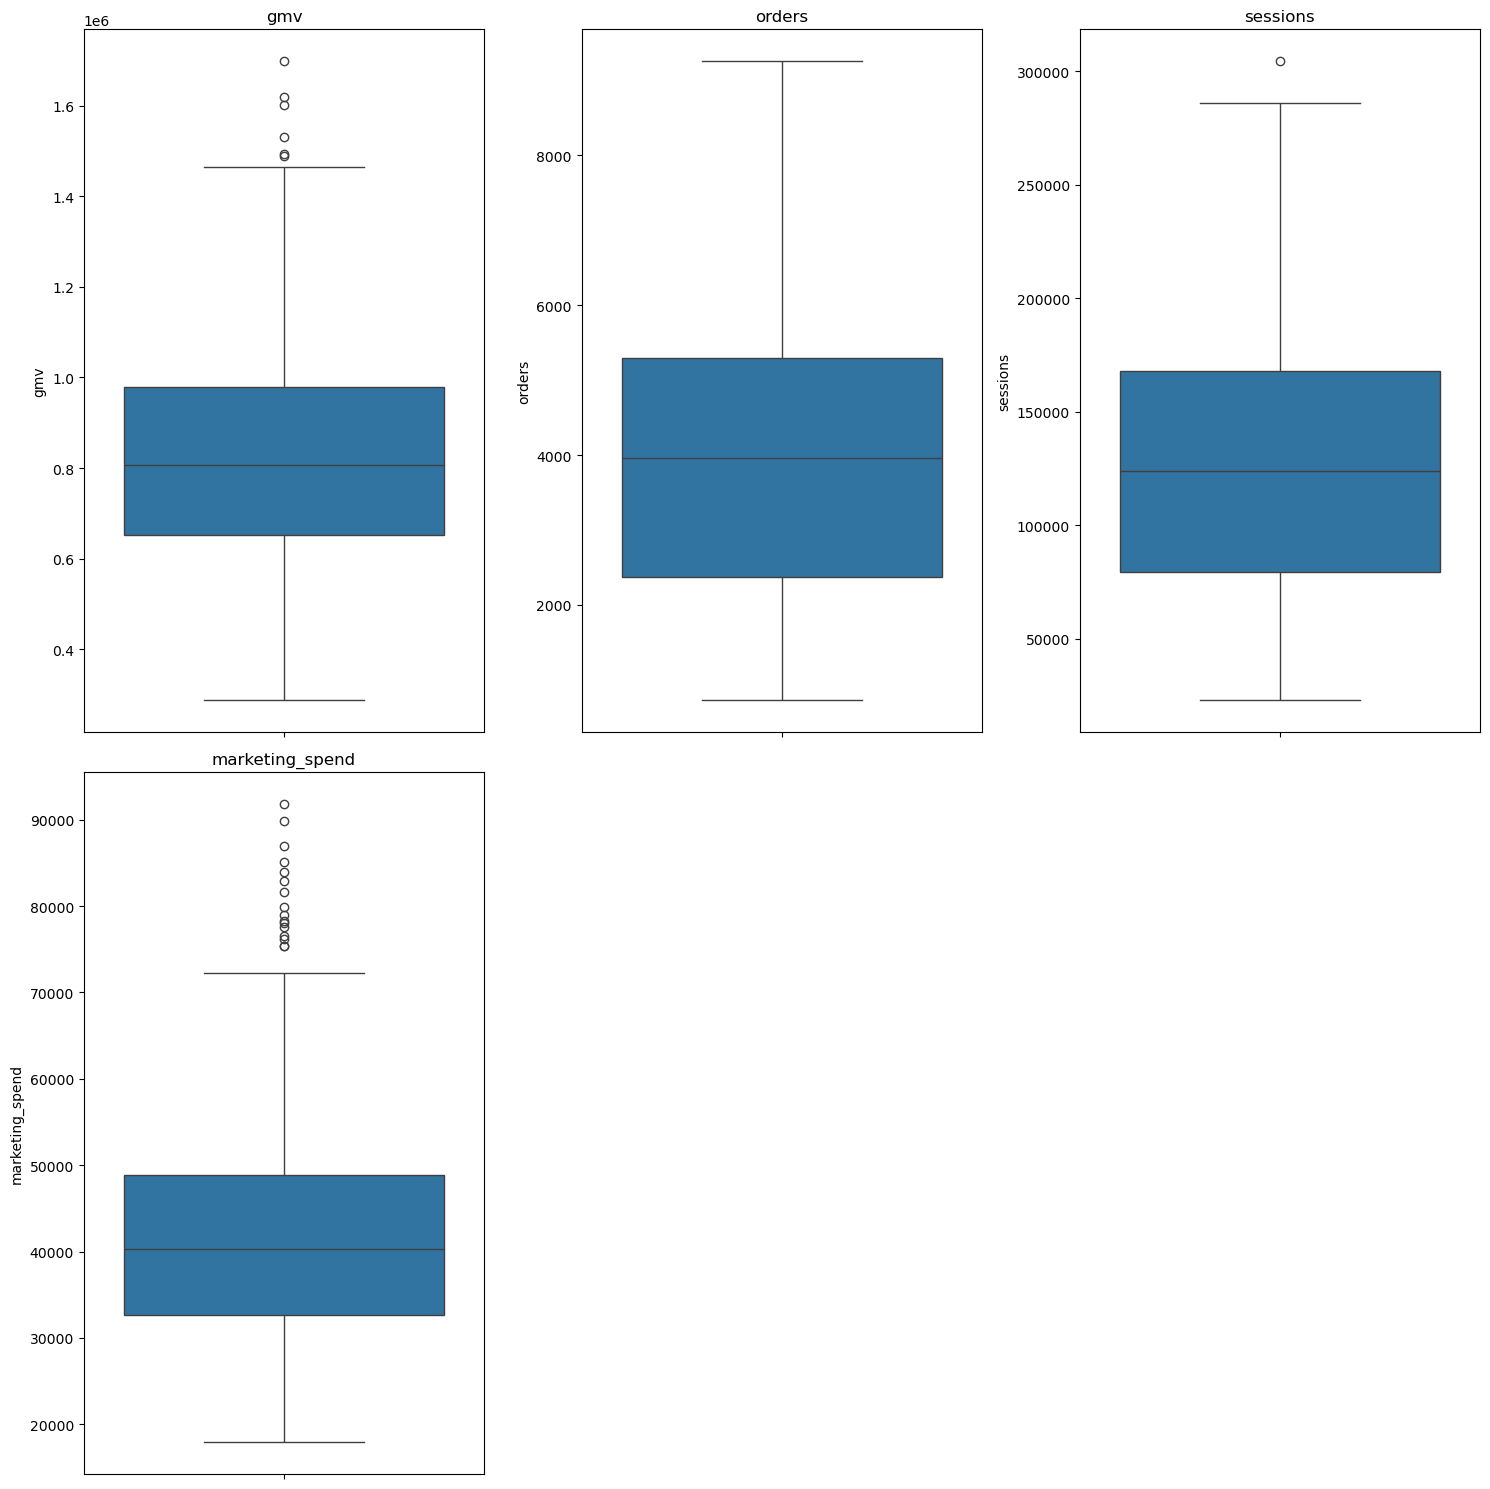

In [12]:

plt.figure(figsize=(15,15))

for i, col in enumerate(df_to_visuilize.columns[:-1]):
    plt.subplot(len(df_to_visuilize.columns[:-1])//3+1, 3, i+1)
    sns.boxplot(y=df_to_visuilize[col])
    plt.title(col)

plt.tight_layout()
plt.show()


#### Выбросы

In [13]:
outliers = {}
for i, col in enumerate(df_to_visuilize.columns[:-1]):
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)  
    IQR = Q3 - Q1  
    outliers[col] = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]  
    print(f'Количество выбросов в столбце {col}: {len(outliers[col])}')

Количество выбросов в столбце gmv: 6
Количество выбросов в столбце orders: 0
Количество выбросов в столбце sessions: 1
Количество выбросов в столбце marketing_spend: 16


#### Гистограммы:

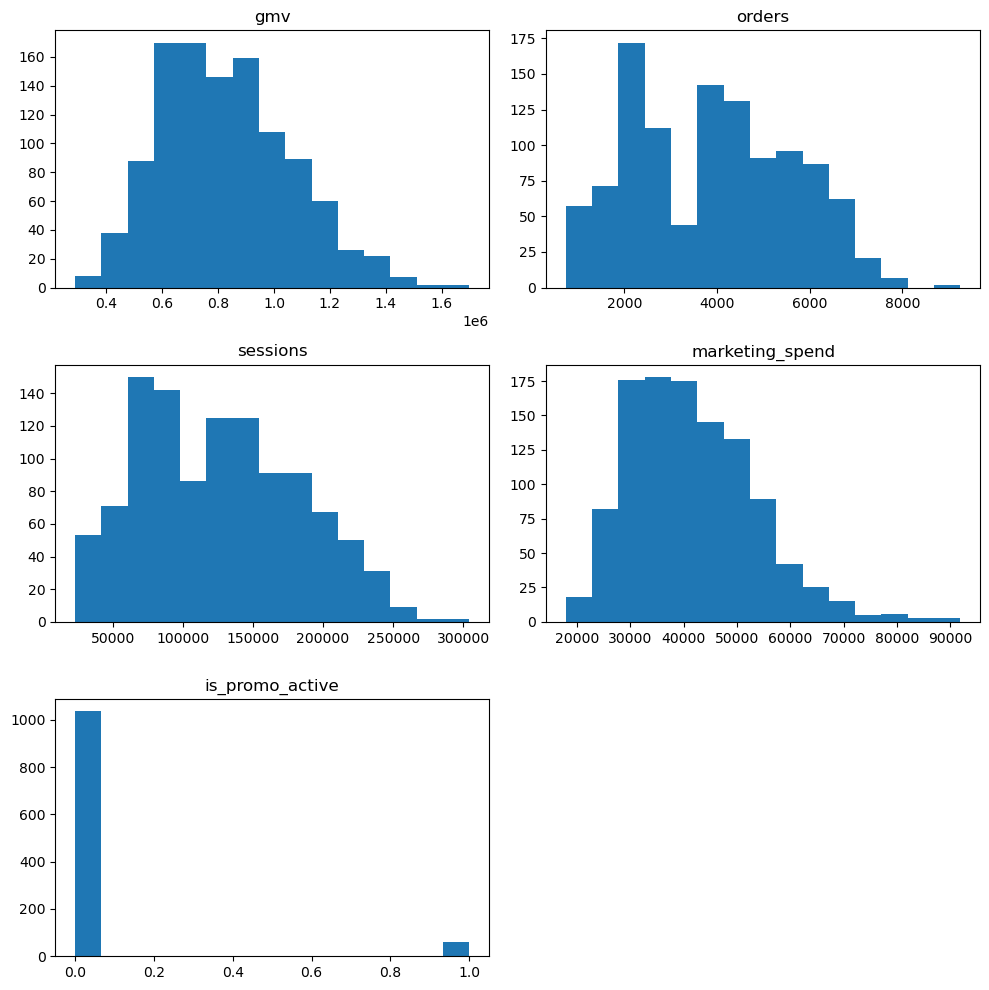

is_promo_active
0    1036
1      59
Name: count, dtype: int64


In [14]:
plt.figure(figsize=(10,10))

buf=[]
for i, col in enumerate(df_to_visuilize.columns):
    plt.subplot(len(df_to_visuilize.columns)//2+1, 2, i+1)
    plt.hist(df_to_visuilize[col], bins=15)
    plt.title(col)
    if len(pd.unique(df_to_visuilize[col])) <11:
        buf.append(df_to_visuilize[col].value_counts())

plt.tight_layout()
plt.show()
for b in buf:
    print(b)

#### Матрица корреляций:

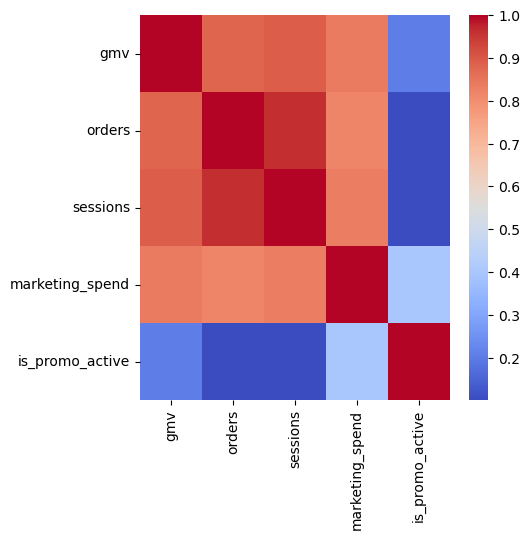

In [15]:
plt.figure(figsize=(5, 5))
sns.heatmap(df_to_visuilize.corr(), annot =False, cmap ="coolwarm")
plt.show()

In [16]:
df_to_visuilize.corr()

,gmv,orders,sessions,marketing_spend,is_promo_active
gmv,1.000000,0.877131,0.893813,0.835916,0.204209
orders,0.877131,1.000000,0.964807,0.820030,0.101176
sessions,0.893813,0.964807,1.000000,0.834204,0.103952
marketing_spend,0.835916,0.820030,0.834204,1.000000,0.396695
is_promo_active,0.204209,0.101176,0.103952,0.396695,1.000000


sessions и orders имеют слишко высокую корреляцию, воизбежание мульиколлениарноти, позде, мы удалим orders

#### Временная зависимость

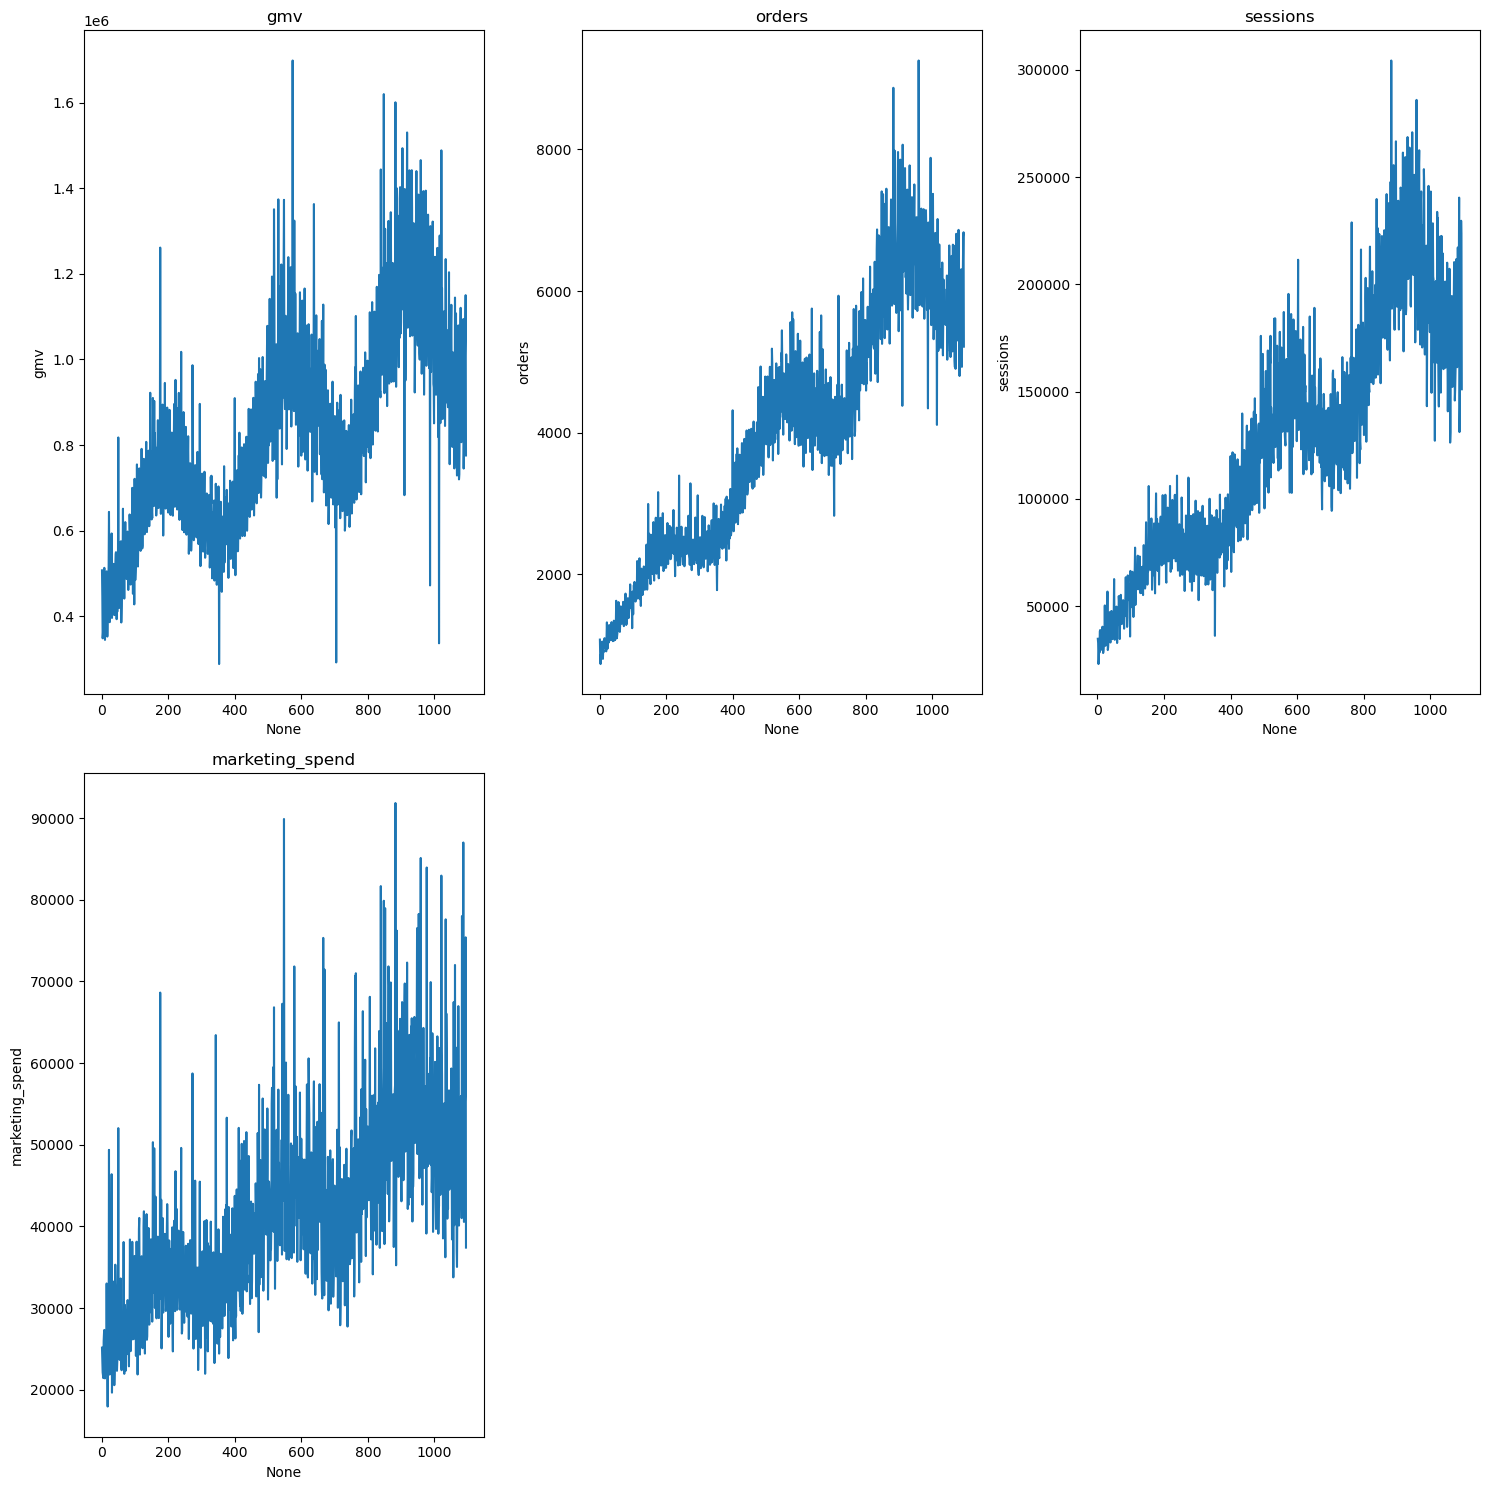

In [17]:

plt.figure(figsize=(15,15))

for i, col in enumerate(df_to_visuilize.columns[:-1]):
    plt.subplot(len(df_to_visuilize.columns[:-1])//3+1, 3, i+1)
    sns.lineplot(y=df_to_visuilize[col], x=df.index+1)
    plt.title(col)

plt.tight_layout()
plt.show()

Видим похожие циклы каждый год

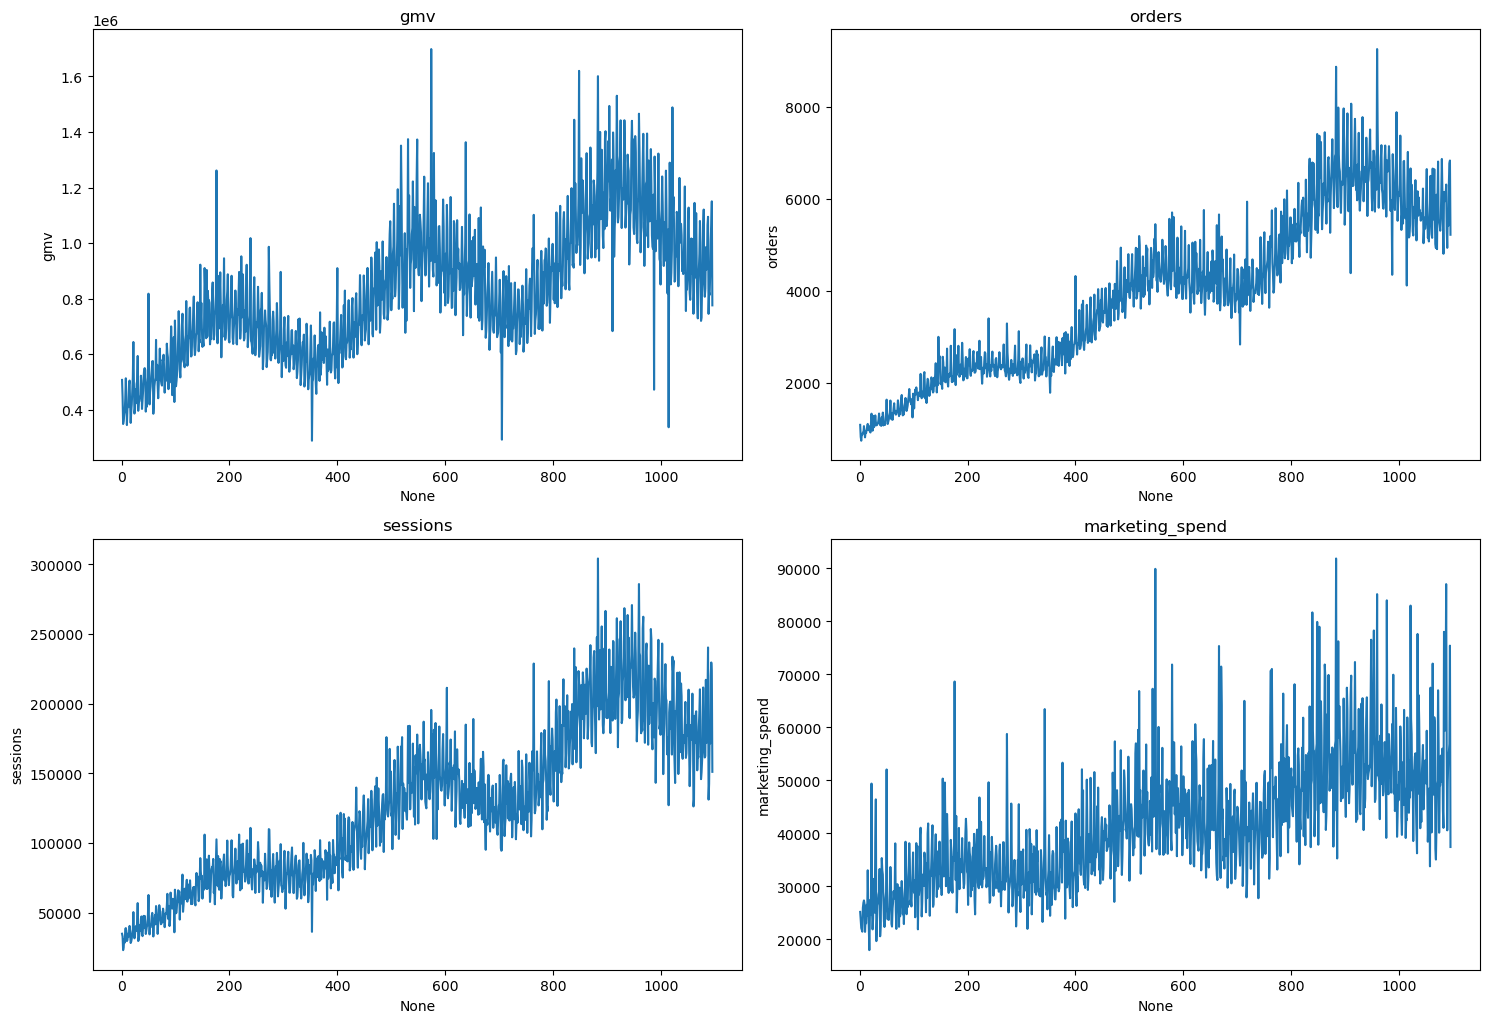

In [18]:

plt.figure(figsize=(15,15))

for i, col in enumerate(df_to_visuilize.columns[:-1]):
    plt.subplot(len(df_to_visuilize.columns[:-1])//2+1, 2, i+1)
    sns.lineplot(y=df_to_visuilize[col], x=df.index+1)
    plt.title(col)

plt.tight_layout()
plt.show()

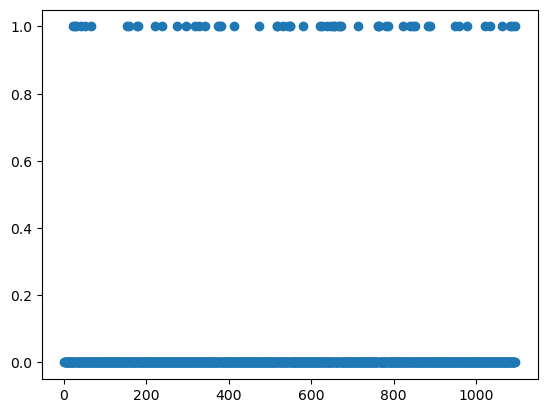

In [19]:
plt.scatter(y=df['is_promo_active'], x=df.index+1)
plt.show()

**Видна сезонность**

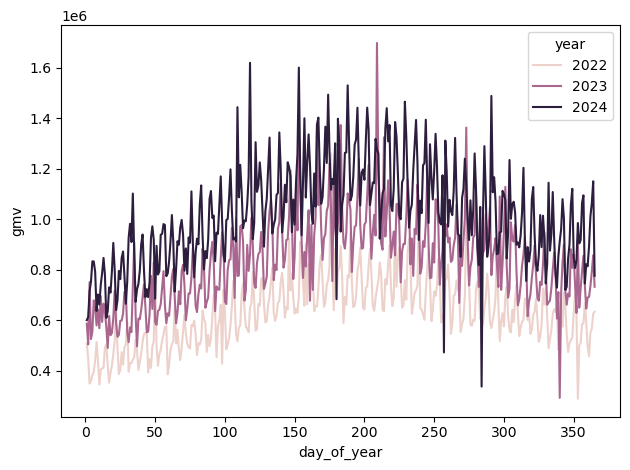

In [20]:
sns.lineplot(data=df, x="day_of_year", y="gmv", hue="year", errorbar=('ci', 95), err_style='band')
plt.tight_layout()
plt.show()

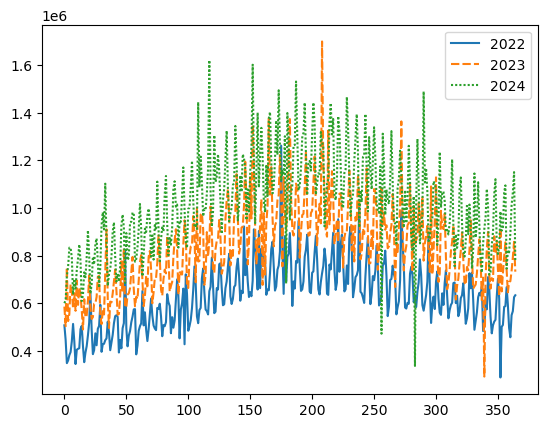

In [21]:
def group_data_by_year(df, column):
    grouped_data = {}
    for year, year_data in df.groupby(by='year'):
        grouped_data[year]=year_data[column].reset_index(drop=True)
    
    return pd.DataFrame(data=grouped_data)

sns.lineplot(data = group_data_by_year(df, 'gmv'), errorbar="sd")
plt.show()

## 2. Подготовка данных и генерация признаков (Feature Engineering).

Удаляем ordes как обещали ранее

In [22]:
df = df.drop(columns=['orders'])
df

,date,gmv,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,date_parsed
0,2022-01-01,506994,34861,25148,0,5,1,52,1,2022,2022-01-01
1,2022-01-02,445834,32858,23769,0,6,2,52,1,2022,2022-01-02
2,2022-01-03,348150,23081,22108,0,0,3,1,1,2022,2022-01-03
3,2022-01-04,359418,25166,21757,0,1,4,1,1,2022,2022-01-04
4,2022-01-05,381439,31082,21420,0,2,5,1,1,2022,2022-01-05
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,171515,54332,0,3,361,52,12,2024,2024-12-26
1091,2024-12-27,1011484,219724,55346,0,4,362,52,12,2024,2024-12-27
1092,2024-12-28,1064332,229631,56839,0,5,363,52,12,2024,2024-12-28
1093,2024-12-29,1150266,223812,75393,1,6,364,52,12,2024,2024-12-29


### 2.1. Feature engineering

- **holiday_proximity** "близость праздника" в зависимости от близости праздника, в который принято дарить подарки в течении следующих десяти дней значение этого будет иметь значения от 0.1 до 1, в остальные дни значение этого признака будет равно 0.

Даты таких праздников:

01.01 - новый год

23.02 - день защитника отечества

08.03 - международные женский день

01.09 - 1-ое сентрября не совсем вписывается в остальные, но тем не менее к этой дате люди часто покупают вещи

In [23]:
gift_holidays = ['01-01', '02-23', '03-08', '01-09']

df['holiday_proximity']=df['date'].apply(lambda x: 1 if x[-5:] in gift_holidays else 0)
df[['holiday_proximity', 'date']][df['holiday_proximity']==1]

,holiday_proximity,date
0,1,2022-01-01
8,1,2022-01-09
53,1,2022-02-23
66,1,2022-03-08
365,1,2023-01-01
373,1,2023-01-09
418,1,2023-02-23
431,1,2023-03-08
730,1,2024-01-01
738,1,2024-01-09


In [24]:
import pandas as pd
from datetime import datetime, timedelta

# Даты праздников (формат 'MM-DD')
gift_holidays = ['01-01', '02-23', '03-08', '09-01']

def calculate_holiday_proximity(date_str, holiday_dates=gift_holidays, days_before=9):
    """
    Возвращает значение от 0.1 до 1, если до праздника осталось <=10 дней, иначе 0.
    
    Параметры:
    - date_str: Дата в формате строки (например, '2023-02-20')
    - holiday_dates: Список праздников в формате 'MM-DD'
    - days_before: За сколько дней до праздника начинается "близость" (по умолчанию 10)
    
    Возвращает:
    - float: Значение от 0.1 до 1 (чем ближе к празднику, тем выше)
    """
    try:
        current_date = datetime.strptime(date_str, '%Y-%m-%d').date()
    except:
        return 0.0  # если дата некорректна
    
    max_proximity = 0.0
    
    for holiday in holiday_dates:
        # Получаем дату праздника в текущем году
        holiday_date = datetime.strptime(f"{current_date.year}-{holiday}", '%Y-%m-%d').date()
        
        # Если праздник уже прошел в этом году, проверяем следующий год
        if holiday_date < current_date:
            holiday_date = datetime.strptime(f"{current_date.year + 1}-{holiday}", '%Y-%m-%d').date()
        
        # Вычисляем разницу в днях
        delta = (holiday_date - current_date).days
        
        # Если до праздника <=10 дней, вычисляем "близость" (1 - в сам праздник, 0.1 - за 10 дней)
        if 0 <= delta <= days_before:
            proximity = 1.0 - (delta / days_before) * 0.9  # линейное убывание от 1 до 0.1
            if proximity > max_proximity:
                max_proximity = proximity
    
    return round(max_proximity, 2) if max_proximity > 0 else 0.0


df_test = df.copy(deep=True)
df_test['holiday_proximity'] = df_test['date'].apply(calculate_holiday_proximity)
df_test

,date,gmv,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,date_parsed,holiday_proximity
0,2022-01-01,506994,34861,25148,0,5,1,52,1,2022,2022-01-01,1.0
1,2022-01-02,445834,32858,23769,0,6,2,52,1,2022,2022-01-02,0.0
2,2022-01-03,348150,23081,22108,0,0,3,1,1,2022,2022-01-03,0.0
3,2022-01-04,359418,25166,21757,0,1,4,1,1,2022,2022-01-04,0.0
4,2022-01-05,381439,31082,21420,0,2,5,1,1,2022,2022-01-05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,171515,54332,0,3,361,52,12,2024,2024-12-26,0.4
1091,2024-12-27,1011484,219724,55346,0,4,362,52,12,2024,2024-12-27,0.5
1092,2024-12-28,1064332,229631,56839,0,5,363,52,12,2024,2024-12-28,0.6
1093,2024-12-29,1150266,223812,75393,1,6,364,52,12,2024,2024-12-29,0.7


In [25]:
df_test[['date','holiday_proximity']][(df_test['month']==12) & (df_test['year']==2022)].tail(15)

,date,holiday_proximity
350,2022-12-17,0.0
351,2022-12-18,0.0
352,2022-12-19,0.0
353,2022-12-20,0.0
354,2022-12-21,0.0
355,2022-12-22,0.0
356,2022-12-23,0.1
357,2022-12-24,0.2
358,2022-12-25,0.3
359,2022-12-26,0.4


- **Сдвиги** {col}\_lag\_{lag}

Для численных фич на 1, 2, 7, 14, 28, 30, 365 дней 

In [26]:
numeric_columns = df.columns[1:4]
numeric_columns

Index(['gmv', 'sessions', 'marketing_spend'], dtype='object')

In [27]:
df2 = df_test.copy(deep=True)
lags_numeric = [1,2,7, 14, 28, 365]
for lag in lags_numeric:
    for col in numeric_columns:
        df2[f"{col}_lag_{lag}"] = df2[col].shift(lag)

In [28]:
df2[list(df2.columns[:4])+list(df2.columns[-18:])].head(15)

,date,gmv,sessions,marketing_spend,gmv_lag_1,sessions_lag_1,marketing_spend_lag_1,gmv_lag_2,sessions_lag_2,marketing_spend_lag_2,...,marketing_spend_lag_7,gmv_lag_14,sessions_lag_14,marketing_spend_lag_14,gmv_lag_28,sessions_lag_28,marketing_spend_lag_28,gmv_lag_365,sessions_lag_365,marketing_spend_lag_365
0,2022-01-01,506994,34861,25148,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,445834,32858,23769,506994.0,34861.0,25148.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03,348150,23081,22108,445834.0,32858.0,23769.0,506994.0,34861.0,25148.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-04,359418,25166,21757,348150.0,23081.0,22108.0,445834.0,32858.0,23769.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-05,381439,31082,21420,359418.0,25166.0,21757.0,348150.0,23081.0,22108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-01-06,394592,28440,25941,381439.0,31082.0,21420.0,359418.0,25166.0,21757.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2022-01-07,440207,38243,26874,394592.0,28440.0,25941.0,381439.0,31082.0,21420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-01-08,512868,38926,27318,440207.0,38243.0,26874.0,394592.0,28440.0,25941.0,...,25148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2022-01-09,440238,36774,26716,512868.0,38926.0,27318.0,440207.0,38243.0,26874.0,...,23769.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2022-01-10,344412,29591,21380,440238.0,36774.0,26716.0,512868.0,38926.0,27318.0,...,22108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
len(df2.columns)

30

- **Скользящие окна**,

{col}\_mean{window\_size}

Среднее за 30 дней для gmv c лагом в 7 и среднее за последние 30 дней для других численных признаков

{col}\_std{window\_size}

Стандартное отклонение за 30 дней для gmv c лагом в 7 и среднее за последние 30 дней для других численных признаков



In [30]:
df3 = df2.copy(deep=True)
for col in numeric_columns:
    df3[f'{col}_mean7'] = df2[col].rolling(window=7, min_periods=1).mean().round(0)
    df3[f'{col}_mean30'] = df2[col].rolling(window=30, min_periods=1).mean().round(0)

In [31]:
df3[list(df2.columns[:4])+list(df3.columns[-6:])].head(15)

,date,gmv,sessions,marketing_spend,gmv_mean7,gmv_mean30,sessions_mean7,sessions_mean30,marketing_spend_mean7,marketing_spend_mean30
0,2022-01-01,506994,34861,25148,506994.0,506994.0,34861.0,34861.0,25148.0,25148.0
1,2022-01-02,445834,32858,23769,476414.0,476414.0,33860.0,33860.0,24458.0,24458.0
2,2022-01-03,348150,23081,22108,433659.0,433659.0,30267.0,30267.0,23675.0,23675.0
3,2022-01-04,359418,25166,21757,415099.0,415099.0,28992.0,28992.0,23196.0,23196.0
4,2022-01-05,381439,31082,21420,408367.0,408367.0,29410.0,29410.0,22840.0,22840.0
5,2022-01-06,394592,28440,25941,406071.0,406071.0,29248.0,29248.0,23357.0,23357.0
6,2022-01-07,440207,38243,26874,410948.0,410948.0,30533.0,30533.0,23860.0,23860.0
7,2022-01-08,512868,38926,27318,411787.0,423688.0,31114.0,31582.0,24170.0,24292.0
8,2022-01-09,440238,36774,26716,410987.0,425527.0,31673.0,32159.0,24591.0,24561.0
9,2022-01-10,344412,29591,21380,410453.0,417415.0,32603.0,31902.0,24487.0,24243.0


In [32]:
for col in numeric_columns:
    df3[f'{col}_std7'] = df2[col].rolling(window=7, min_periods=1).std().round(0)
    df3[f'{col}_std30'] = df2[col].rolling(window=30, min_periods=1).std().round(0)

df3[list(df2.columns[:4])+list(df3.columns[-6:])].head(15)

,date,gmv,sessions,marketing_spend,gmv_std7,gmv_std30,sessions_std7,sessions_std30,marketing_spend_std7,marketing_spend_std30
0,2022-01-01,506994,34861,25148,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,445834,32858,23769,43247.0,43247.0,1416.0,1416.0,975.0,975.0
2,2022-01-03,348150,23081,22108,80119.0,80119.0,6303.0,6303.0,1522.0,1522.0
3,2022-01-04,359418,25166,21757,75215.0,75215.0,5744.0,5744.0,1570.0,1570.0
4,2022-01-05,381439,31082,21420,66855.0,66855.0,5061.0,5061.0,1574.0,1574.0
5,2022-01-06,394592,28440,25941,60061.0,60061.0,4544.0,4544.0,1893.0,1893.0
6,2022-01-07,440207,38243,26874,56325.0,56325.0,5363.0,5363.0,2181.0,2181.0
7,2022-01-08,512868,38926,27318,58013.0,63386.0,6082.0,5785.0,2522.0,2360.0
8,2022-01-09,440238,36774,26716,57502.0,59548.0,6439.0,5681.0,2684.0,2351.0
9,2022-01-10,344412,29591,21380,58196.0,61725.0,5373.0,5417.0,2808.0,2434.0


In [33]:
len(df3.columns)

42

- **Счетчики**
>Идея состоит в том, чтобы группировать данные не только по временным факторам, но и по любым категориальным. Например, пусть сегодня нет ветра. Тогда в качестве признака можно рассмотреть среднюю температуру в безветренные дни по историческим данным.
>
>Можно также использовать сразу несколько факторов. Например, мы строим прогноз в апреле. Тогда можно рассматривать среднюю температуру в безветренные дни в апреле по историческим данным.

{col}\_mean30\_with\_promo

{col}\_mean30\_without\_promo

В данном случае мы группируем по наличию промо акции

In [34]:
# Функция для вычисления среднего по флагу в окне
def calc_conditional_mean(series, flag_series, flag_value, lag):
    return series.where(flag_series == flag_value).shift(lag).rolling(window=30, min_periods=1).mean().round(0)

In [35]:
df4 = df3.copy(deep=True)
for col in numeric_columns:
    df4[f'{col}_mean30_with_promo'] = calc_conditional_mean(df4[col], df4['is_promo_active'], 1, 0)
    df4[f'{col}_mean30_without_promo'] = calc_conditional_mean(df4[col], df4['is_promo_active'], 0, 0)

df4[list(df4.columns[:5])+list(df4.columns[-6:])].head(30)

,date,gmv,sessions,marketing_spend,is_promo_active,gmv_mean30_with_promo,gmv_mean30_without_promo,sessions_mean30_with_promo,sessions_mean30_without_promo,marketing_spend_mean30_with_promo,marketing_spend_mean30_without_promo
0,2022-01-01,506994,34861,25148,0,NaN,506994.0,NaN,34861.0,NaN,25148.0
1,2022-01-02,445834,32858,23769,0,NaN,476414.0,NaN,33860.0,NaN,24458.0
2,2022-01-03,348150,23081,22108,0,NaN,433659.0,NaN,30267.0,NaN,23675.0
3,2022-01-04,359418,25166,21757,0,NaN,415099.0,NaN,28992.0,NaN,23196.0
4,2022-01-05,381439,31082,21420,0,NaN,408367.0,NaN,29410.0,NaN,22840.0
5,2022-01-06,394592,28440,25941,0,NaN,406071.0,NaN,29248.0,NaN,23357.0
6,2022-01-07,440207,38243,26874,0,NaN,410948.0,NaN,30533.0,NaN,23860.0
7,2022-01-08,512868,38926,27318,0,NaN,423688.0,NaN,31582.0,NaN,24292.0
8,2022-01-09,440238,36774,26716,0,NaN,425527.0,NaN,32159.0,NaN,24561.0
9,2022-01-10,344412,29591,21380,0,NaN,417415.0,NaN,31902.0,NaN,24243.0


In [36]:
len(df4.columns)

48

In [37]:
df4[df4.columns[:11]]

,date,gmv,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,date_parsed
0,2022-01-01,506994,34861,25148,0,5,1,52,1,2022,2022-01-01
1,2022-01-02,445834,32858,23769,0,6,2,52,1,2022,2022-01-02
2,2022-01-03,348150,23081,22108,0,0,3,1,1,2022,2022-01-03
3,2022-01-04,359418,25166,21757,0,1,4,1,1,2022,2022-01-04
4,2022-01-05,381439,31082,21420,0,2,5,1,1,2022,2022-01-05
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,171515,54332,0,3,361,52,12,2024,2024-12-26
1091,2024-12-27,1011484,219724,55346,0,4,362,52,12,2024,2024-12-27
1092,2024-12-28,1064332,229631,56839,0,5,363,52,12,2024,2024-12-28
1093,2024-12-29,1150266,223812,75393,1,6,364,52,12,2024,2024-12-29


- **Периодичные временные промежутки в синусоиду**

{col}\_sin

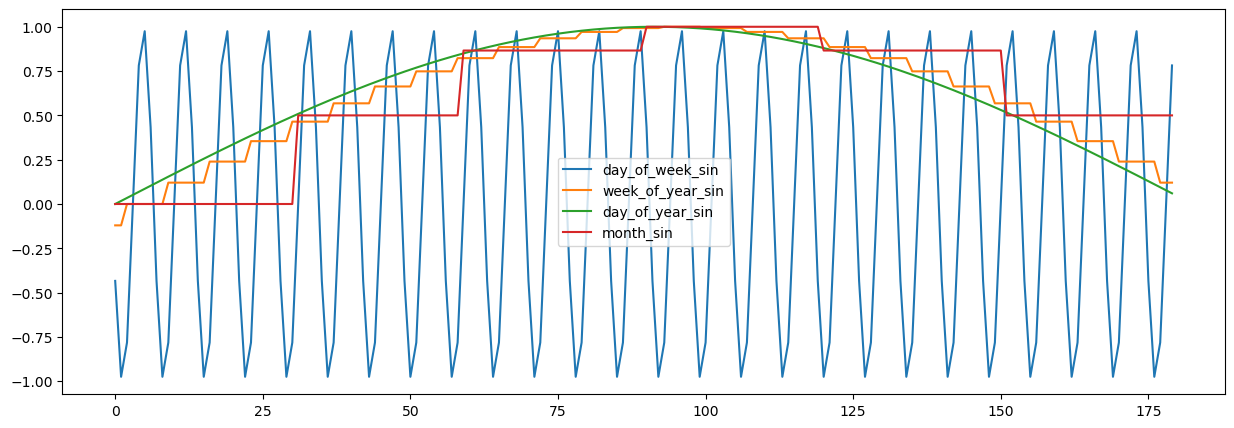

In [38]:
plt.figure(figsize=(15,5))

df5 = df4.copy(deep=True)
df5['day_of_week_sin'] = np.sin(2 * np.pi * (df5['day_of_week']-1) / 7)
df5['week_of_year_sin'] = np.sin(2 * np.pi * (df5['week_of_year']-1) / 52)
df5['day_of_year_sin'] = np.sin(2 * np.pi * (df5['day_of_year']-1) / 365)
df5['month_sin'] = np.sin(2 * np.pi * (df5['month']-1) / 12)
plt.plot(df5['day_of_week_sin'][:180], label = 'day_of_week_sin')
plt.plot(df5['week_of_year_sin'][:180], label = 'week_of_year_sin')
plt.plot(df5['day_of_year_sin'][:180], label = 'day_of_year_sin')
plt.plot(df5['month_sin'][:180], label = 'month_sin')

plt.legend()
plt.show()

- **Год в виде последовательнсоти**

Данные о годе было решено преобразовать в последовательность:

2022 - 1, 2023 - 2, 2024 - 3

Так как год не является периодичным признаком, то его можно заменить на последовательность натуральных чисел начиная с 1

In [39]:
df5['year_fixed'] = df5['year']-2021
df5['year_fixed'].value_counts()

year_fixed
1    365
2    365
3    365
Name: count, dtype: int64

In [40]:
len(df5.columns)

53

### 2.2. Заполнение пропусков

Изначально пропусков не было но после доабвления признаков с "лагом" в начале многих признаков есть пропущенные значения.

In [41]:
nans = df5.isna().sum()[df5.isna().sum()>0]
nans

gmv_lag_1                              1
sessions_lag_1                         1
marketing_spend_lag_1                  1
gmv_lag_2                              2
sessions_lag_2                         2
marketing_spend_lag_2                  2
gmv_lag_7                              7
sessions_lag_7                         7
marketing_spend_lag_7                  7
gmv_lag_14                            14
sessions_lag_14                       14
marketing_spend_lag_14                14
gmv_lag_28                            28
sessions_lag_28                       28
marketing_spend_lag_28                28
gmv_lag_365                          365
sessions_lag_365                     365
marketing_spend_lag_365              365
gmv_std7                               1
gmv_std30                              1
sessions_std7                          1
sessions_std30                         1
marketing_spend_std7                   1
marketing_spend_std30                  1
gmv_mean30_with_

#### Там где немного пропусков заполняю просто следующим в столбце

In [42]:
small_nans = nans[nans<7]
small_nans

gmv_lag_1                1
sessions_lag_1           1
marketing_spend_lag_1    1
gmv_lag_2                2
sessions_lag_2           2
marketing_spend_lag_2    2
gmv_std7                 1
gmv_std30                1
sessions_std7            1
sessions_std30           1
marketing_spend_std7     1
marketing_spend_std30    1
dtype: int64

In [43]:
small_nans.index

Index(['gmv_lag_1', 'sessions_lag_1', 'marketing_spend_lag_1', 'gmv_lag_2',
       'sessions_lag_2', 'marketing_spend_lag_2', 'gmv_std7', 'gmv_std30',
       'sessions_std7', 'sessions_std30', 'marketing_spend_std7',
       'marketing_spend_std30'],
      dtype='object')

In [44]:
df6 = df5.copy(deep=True)
for col in list(small_nans.index):
    df6[col] = df6[col].bfill()

df6[list(small_nans.index)].isna().sum()

gmv_lag_1                0
sessions_lag_1           0
marketing_spend_lag_1    0
gmv_lag_2                0
sessions_lag_2           0
marketing_spend_lag_2    0
gmv_std7                 0
gmv_std30                0
sessions_std7            0
sessions_std30           0
marketing_spend_std7     0
marketing_spend_std30    0
dtype: int64

In [45]:
df6[list(small_nans.index)].head(5)

,gmv_lag_1,sessions_lag_1,marketing_spend_lag_1,gmv_lag_2,sessions_lag_2,marketing_spend_lag_2,gmv_std7,gmv_std30,sessions_std7,sessions_std30,marketing_spend_std7,marketing_spend_std30
0,506994.0,34861.0,25148.0,506994.0,34861.0,25148.0,43247.0,43247.0,1416.0,1416.0,975.0,975.0
1,506994.0,34861.0,25148.0,506994.0,34861.0,25148.0,43247.0,43247.0,1416.0,1416.0,975.0,975.0
2,445834.0,32858.0,23769.0,506994.0,34861.0,25148.0,80119.0,80119.0,6303.0,6303.0,1522.0,1522.0
3,348150.0,23081.0,22108.0,445834.0,32858.0,23769.0,75215.0,75215.0,5744.0,5744.0,1570.0,1570.0
4,359418.0,25166.0,21757.0,348150.0,23081.0,22108.0,66855.0,66855.0,5061.0,5061.0,1574.0,1574.0


#### Заполнение остальных пропусков в столбцах

In [46]:
mid_nans = nans[(nans>=7)&(nans<200)]
mid_nans

gmv_lag_7                  7
sessions_lag_7             7
marketing_spend_lag_7      7
gmv_lag_14                14
sessions_lag_14           14
marketing_spend_lag_14    14
gmv_lag_28                28
sessions_lag_28           28
marketing_spend_lag_28    28
dtype: int64

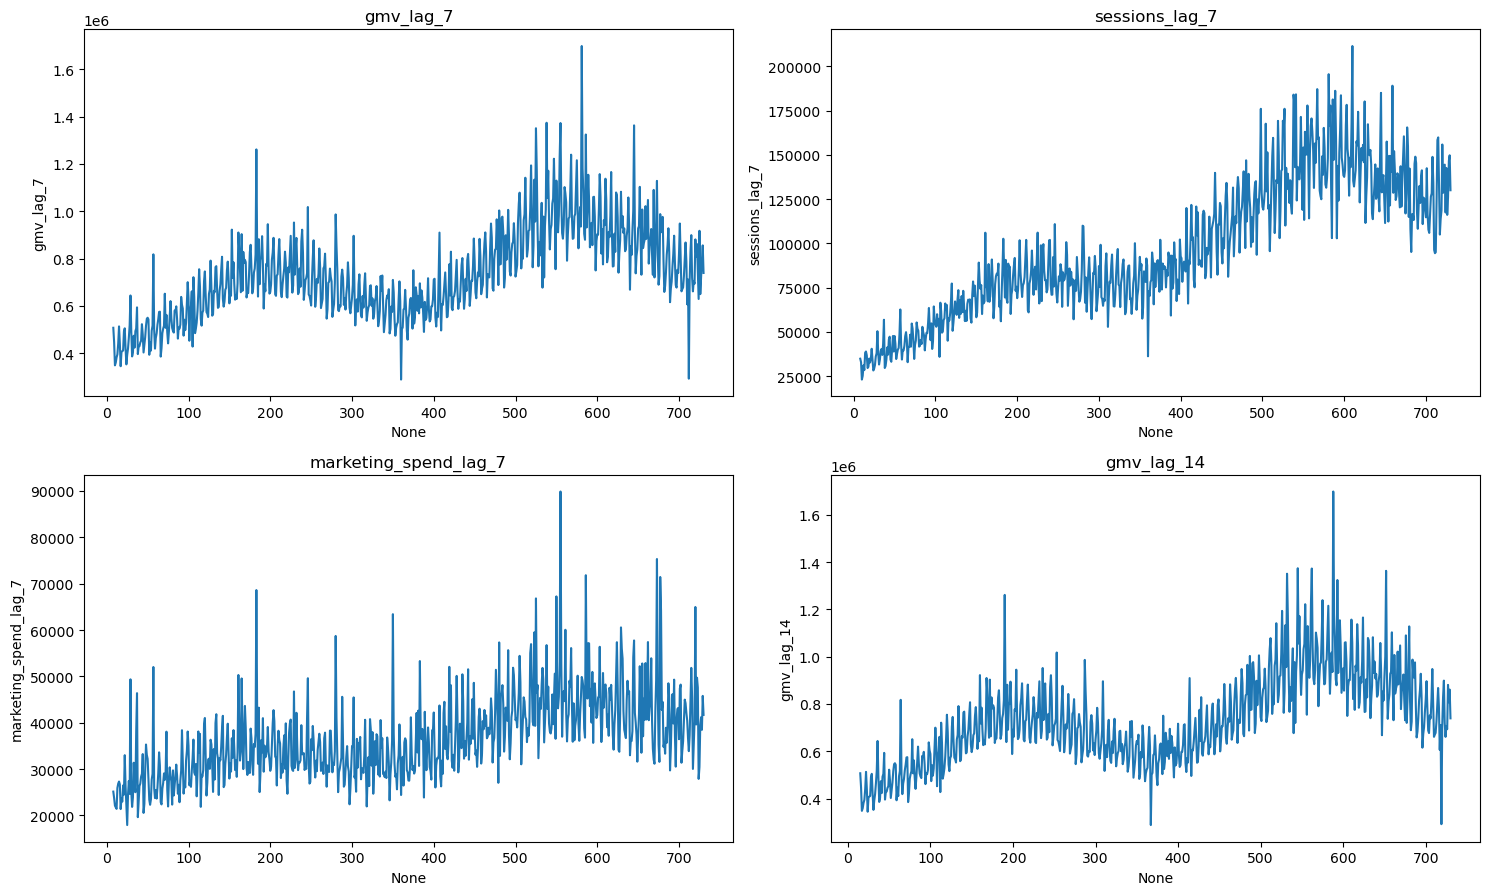

In [47]:

plt.figure(figsize=(15,120))

for i, col in enumerate(list(mid_nans.index)[:4]):
    plt.subplot(len(df6.columns[:-1])//2+1, 2, i+1)
    sns.lineplot(y=df6[:730][col], x=df6[:730].index+1)
    plt.title(col)

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


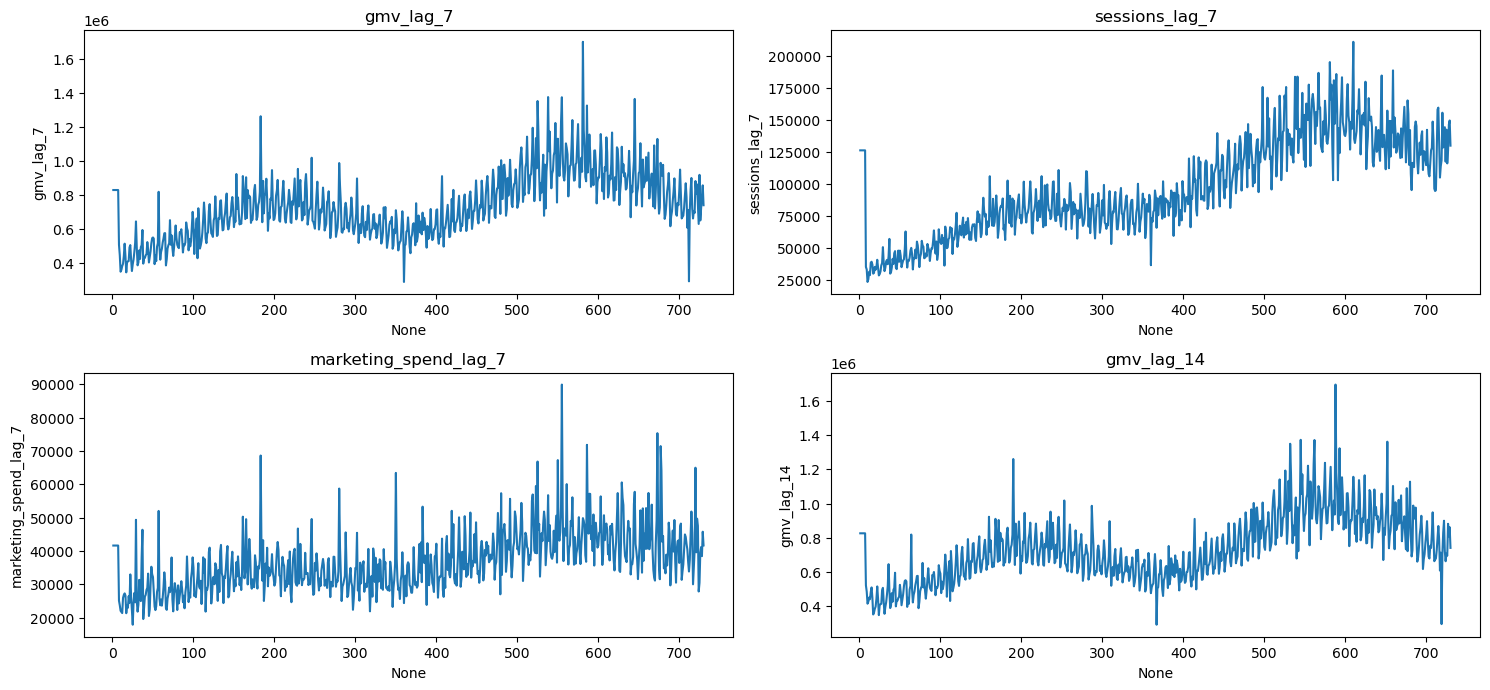

In [48]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_test_fill_mid_nan_features = df6[list(mid_nans.index)].copy(deep=True)

imputer = IterativeImputer(random_state=42)
raw_data = imputer.fit_transform(df_test_fill_mid_nan_features)
df_test_fill_mid_nan_features = pd.DataFrame(raw_data, columns = df_test_fill_mid_nan_features.columns)

plt.figure(figsize=(15,10))

for i, col in enumerate(df_test_fill_mid_nan_features.columns[:4]):
    plt.subplot(len(df_test_fill_mid_nan_features.columns[:4])//2+1, 2, i+1)
    sns.lineplot(y=df_test_fill_mid_nan_features[:730][col], x=df_test_fill_mid_nan_features[:730].index+1)
    plt.title(col)

plt.tight_layout()
plt.show()


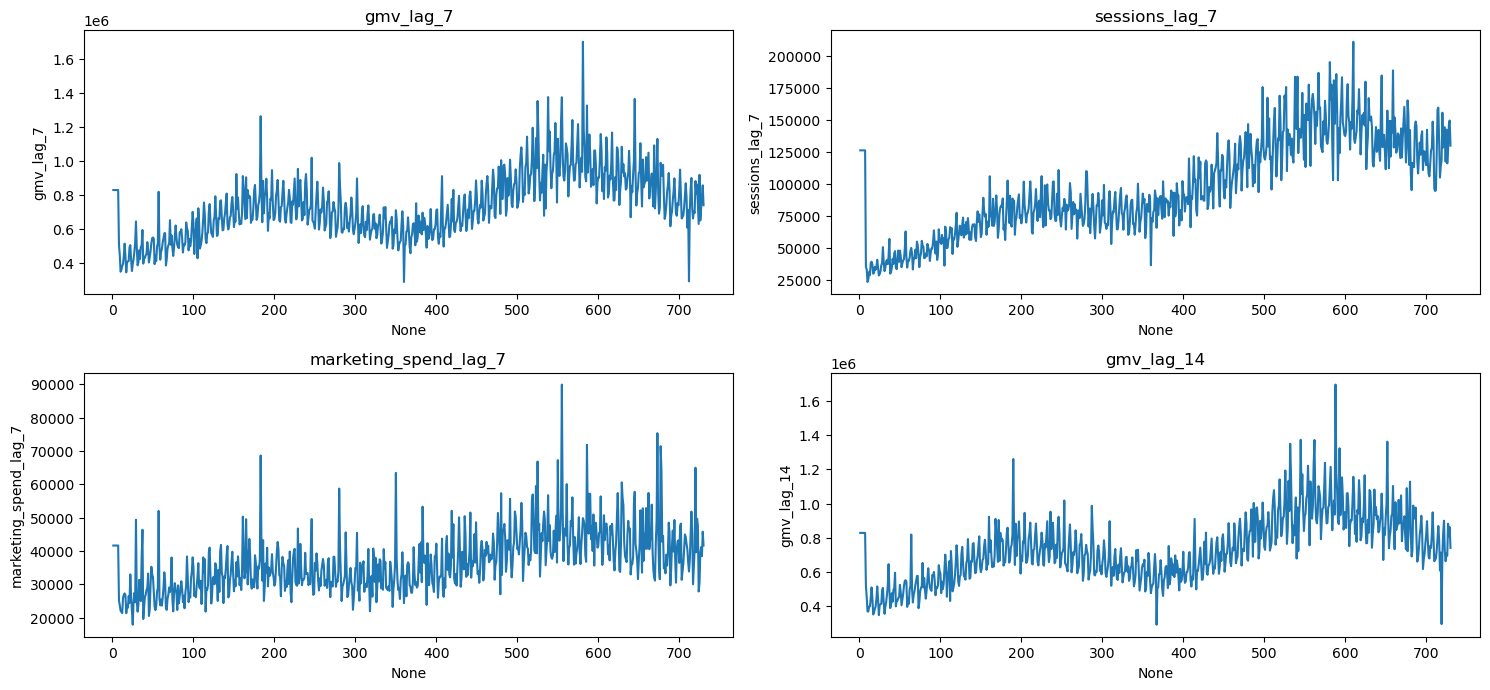

In [49]:
from sklearn.impute import KNNImputer
df_test_fill_mid_nan_features = df6[list(mid_nans.index)].copy(deep=True)

imputer = KNNImputer(n_neighbors=4, weights="uniform")
raw_data = imputer.fit_transform(df_test_fill_mid_nan_features)
df_test_fill_mid_nan_features = pd.DataFrame(raw_data, columns = df_test_fill_mid_nan_features.columns)

plt.figure(figsize=(15,10))

for i, col in enumerate(df_test_fill_mid_nan_features.columns[:4]):
    plt.subplot(len(df_test_fill_mid_nan_features.columns[:4])//2+1, 2, i+1)
    sns.lineplot(y=df_test_fill_mid_nan_features[:730][col], x=df_test_fill_mid_nan_features[:730].index+1)
    plt.title(col)

plt.tight_layout()
plt.show()

Результат интерполяции выше неудовлетворительный, поэтому напишем собственную, наивную

In [50]:
#Берем отрезок указанной длины дальше и вставляем на место пропусков, опустив до того же уровня
def custom_naive_season_interpolation(ser, nan_count):
    buf = ser[nan_count: 2*nan_count+1]
    lag = buf.iloc[-1] - buf.iloc[0]
    buf = buf - lag
    buf = buf[:-1].reset_index(drop=True)
    return pd.concat([buf, ser[nan_count:]])

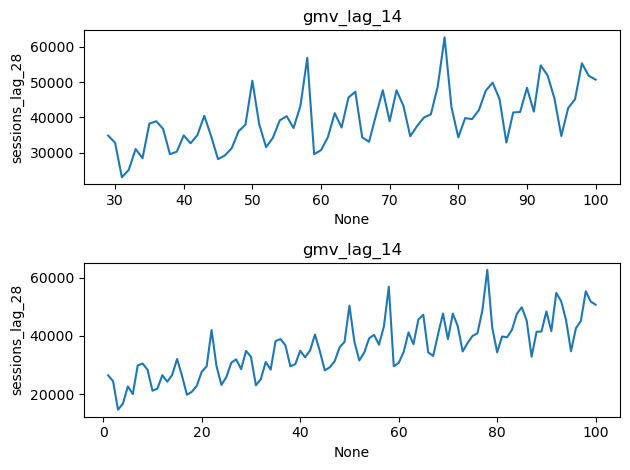

In [51]:
ser1 = df6['sessions_lag_28'][:100]
ser2 = custom_naive_season_interpolation(ser1, 28)


plt.subplot(2, 1, 1)
sns.lineplot(y=ser1, x=ser1.index+1)
plt.title(col)


plt.subplot(2, 1, 2)
sns.lineplot(y=ser2, x=ser2.index+1)
plt.title(col)

                            
plt.tight_layout()
plt.show()

In [52]:
lag_columns = list(set([col for col in df6.columns if "_lag_" in col]) - set(list(small_nans.index)))
lag_columns

['gmv_lag_28',
 'marketing_spend_lag_28',
 'marketing_spend_lag_7',
 'gmv_lag_7',
 'marketing_spend_lag_14',
 'sessions_lag_7',
 'gmv_lag_365',
 'marketing_spend_lag_365',
 'sessions_lag_14',
 'sessions_lag_28',
 'gmv_lag_14',
 'sessions_lag_365']

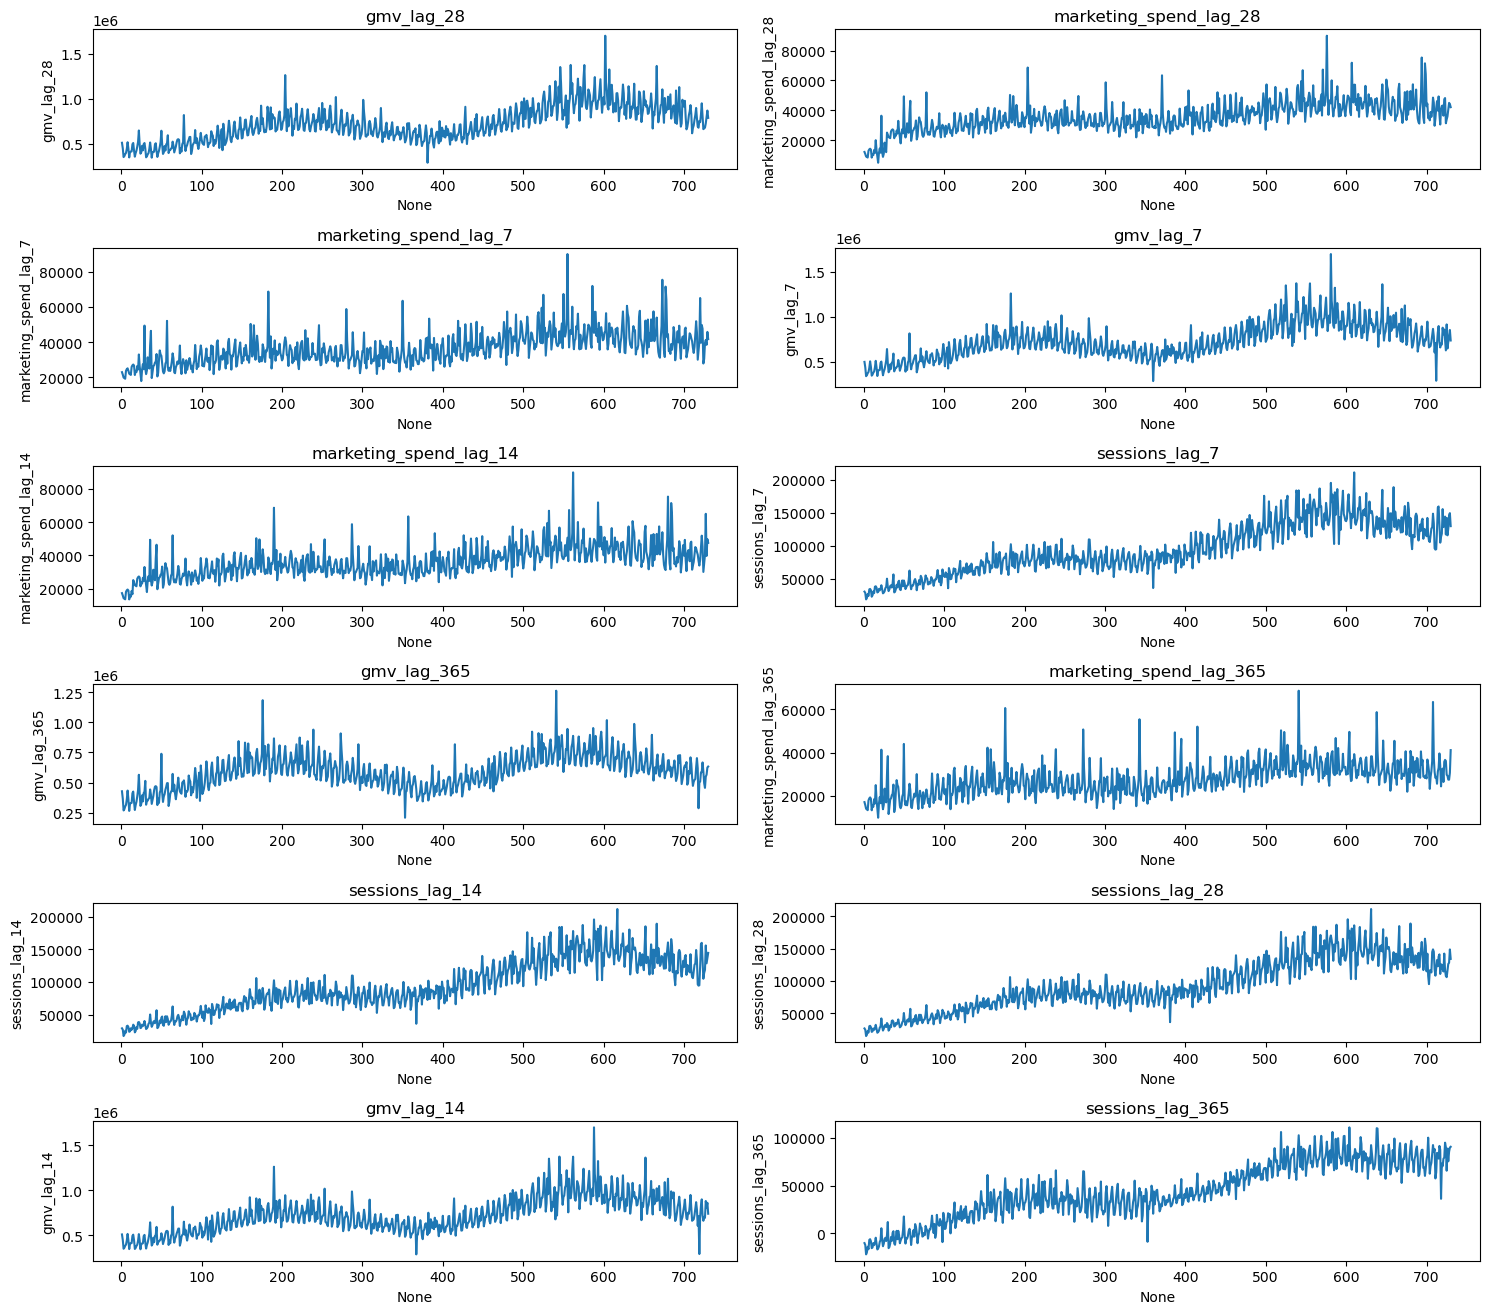

In [53]:
df7 = df6.copy(deep=True)


for col in lag_columns:
    df7[col] = custom_naive_season_interpolation(df7[col], int(re.search(r'\d+$', col).group()))

plt.figure(figsize=(15,15))

for i, col in enumerate(lag_columns):
    plt.subplot(len(lag_columns)//2+1, 2, i+1)
    sns.lineplot(y=df7[:730][col], x=df7[:730].index+1)
    plt.title(col)

plt.tight_layout()
plt.show()

In [54]:
df8 = df7.copy(deep=True)
big_window_nans = df8.isna().sum()[df8.isna().sum()>0]
big_window_nans

gmv_mean30_with_promo                235
sessions_mean30_with_promo           235
marketing_spend_mean30_with_promo    235
dtype: int64

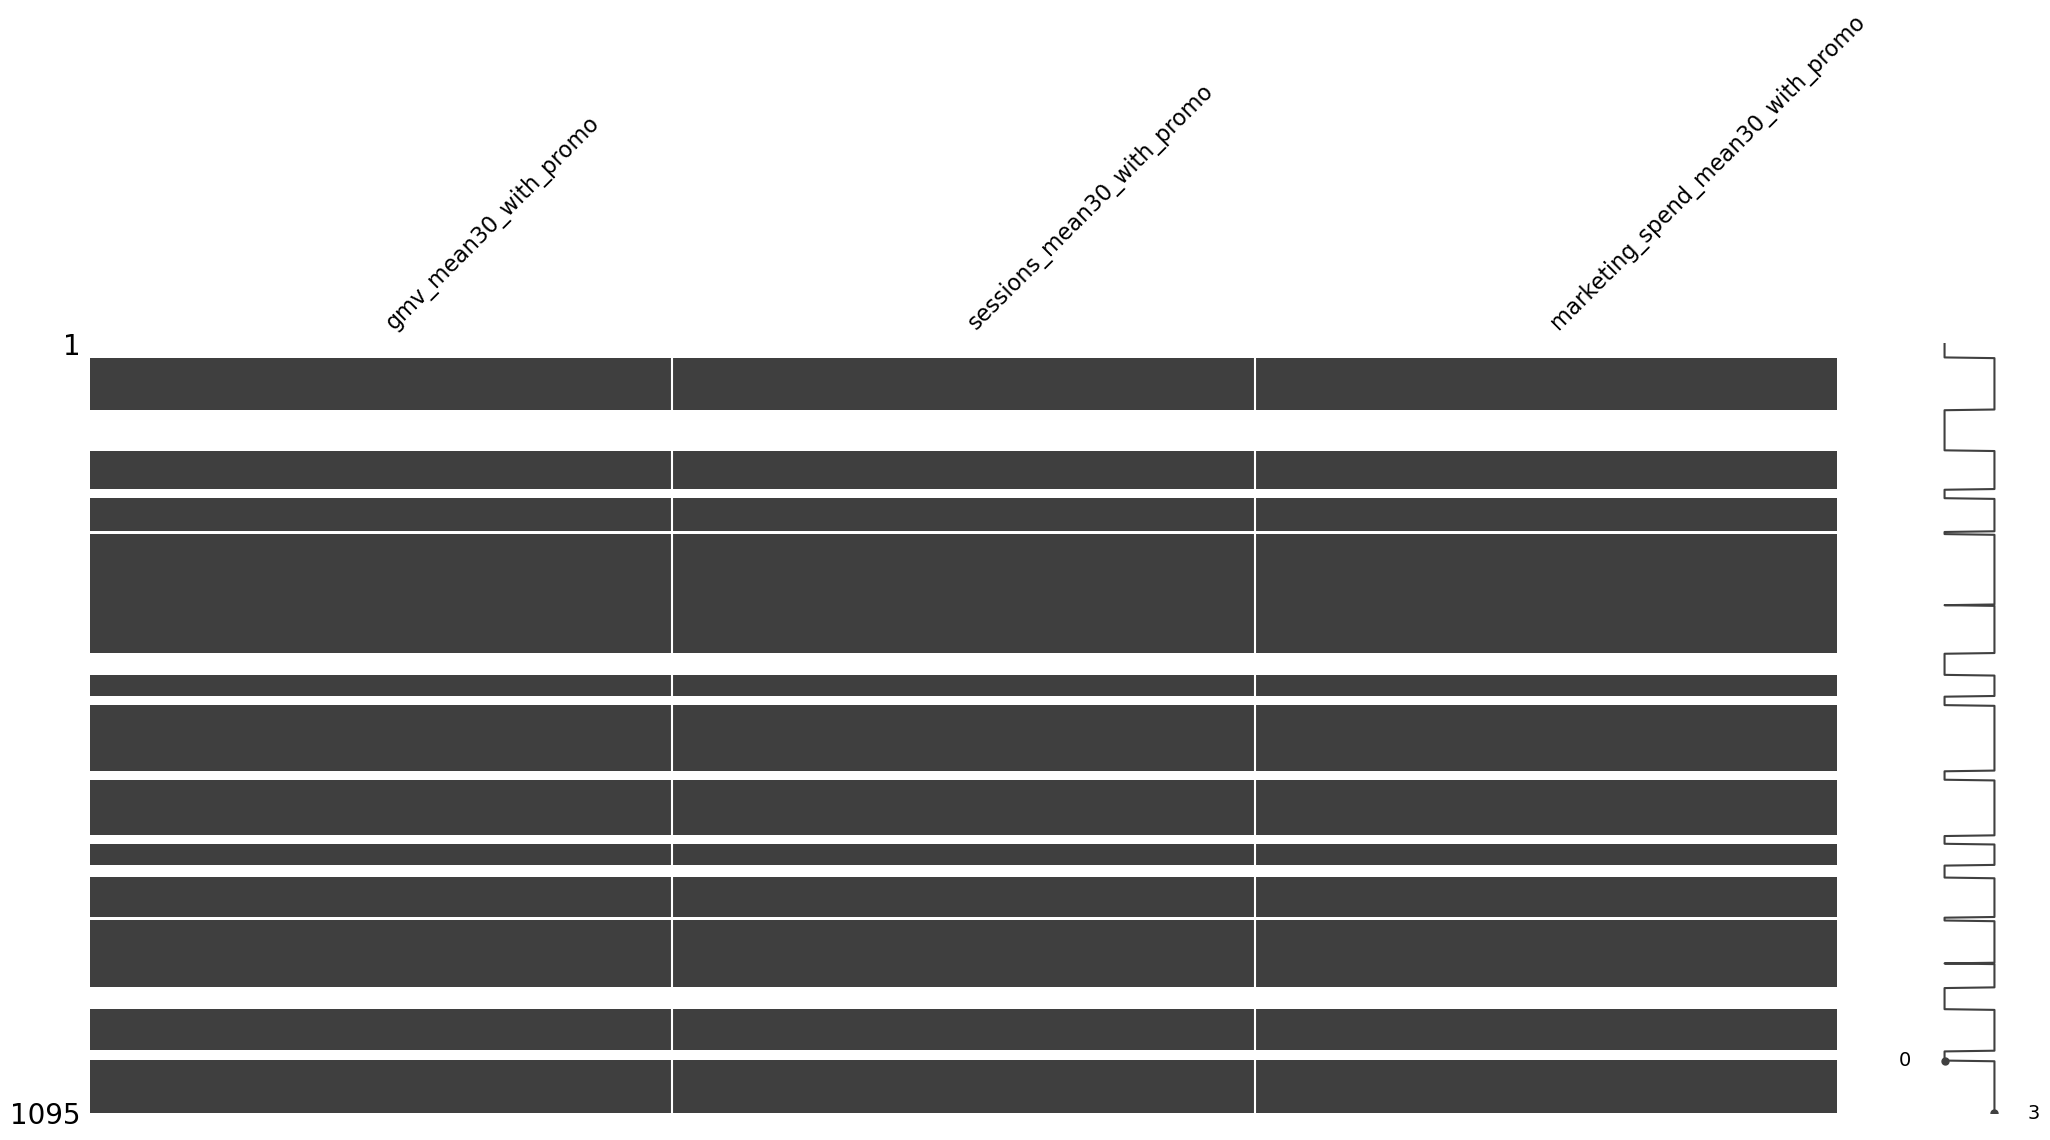

In [55]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df7[list(big_window_nans.index)])  # Визуализация пропусков (белые полосы — NaN)
plt.show()

Как можно видеть, из-за того, что часто перерывы между акциями больше, чем размер окна, то возникают зазоры в данных на протяжении всего датасета, а значит прошлый метод для них не подойдет (однако для пропусков в начале применим)

In [56]:
big_window_nans_cols = list(big_window_nans.index)
big_window_nans_cols

['gmv_mean30_with_promo',
 'sessions_mean30_with_promo',
 'marketing_spend_mean30_with_promo']

Отображаем с помощью scatter т.к. lineplot убирает разрывы в данных


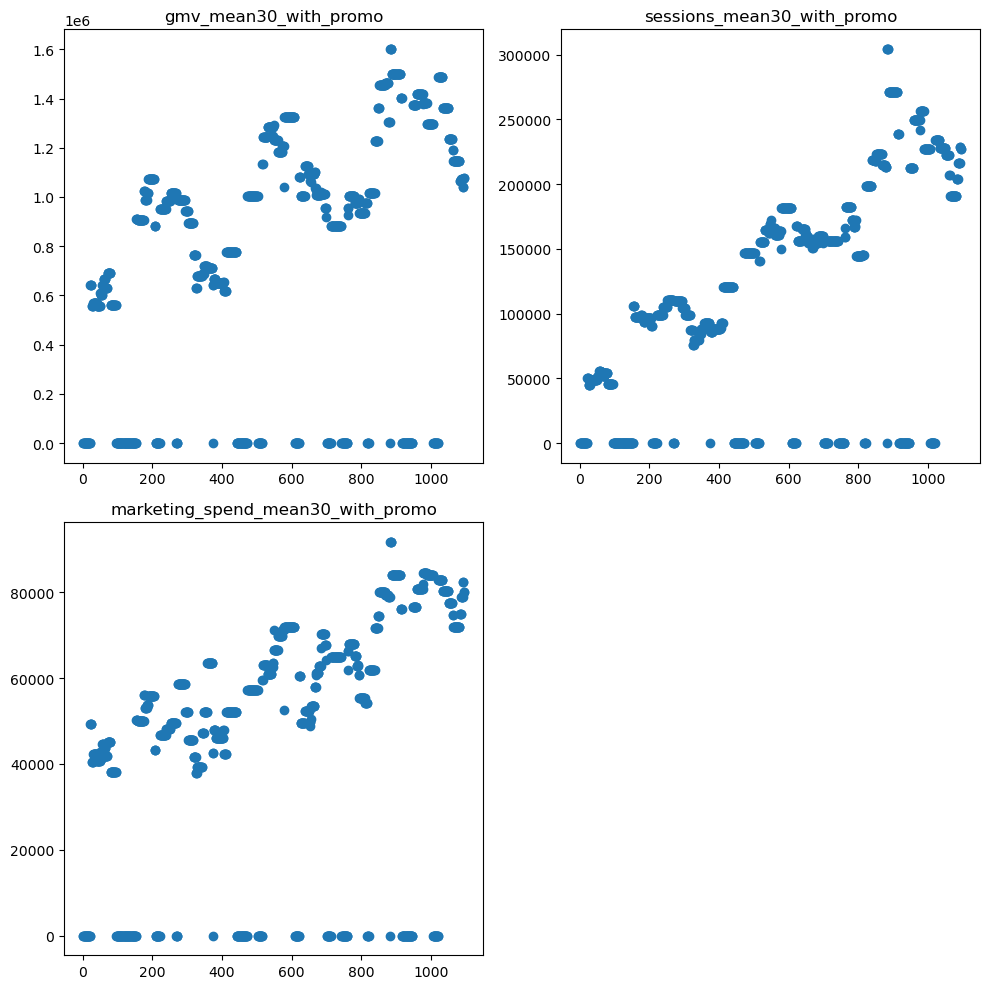

In [57]:
df9 = df8.copy(deep=True)

big_window_nans_cols = list(big_window_nans.index)

for col in big_window_nans_cols:
    df9[col] = df9[col].fillna(0)


plt.figure(figsize=(10,10))

for i, col in enumerate(big_window_nans_cols):
    plt.subplot(len(big_window_nans_cols)//2+1, 2, i+1)
    plt.scatter(y=df9[col], x=df9.index+1)
    plt.title(col)

plt.tight_layout()
print('Отображаем с помощью scatter т.к. lineplot убирает разрывы в данных')
plt.show()

Так как в эти дни отсуствует акция то решено, присвоить пропущенным значениям 0

In [58]:
df9.isna().any().any()

False

Пропуски удалены

In [59]:
df9.columns

Index(['date', 'gmv', 'sessions', 'marketing_spend', 'is_promo_active',
       'day_of_week', 'day_of_year', 'week_of_year', 'month', 'year',
       'date_parsed', 'holiday_proximity', 'gmv_lag_1', 'sessions_lag_1',
       'marketing_spend_lag_1', 'gmv_lag_2', 'sessions_lag_2',
       'marketing_spend_lag_2', 'gmv_lag_7', 'sessions_lag_7',
       'marketing_spend_lag_7', 'gmv_lag_14', 'sessions_lag_14',
       'marketing_spend_lag_14', 'gmv_lag_28', 'sessions_lag_28',
       'marketing_spend_lag_28', 'gmv_lag_365', 'sessions_lag_365',
       'marketing_spend_lag_365', 'gmv_mean7', 'gmv_mean30', 'sessions_mean7',
       'sessions_mean30', 'marketing_spend_mean7', 'marketing_spend_mean30',
       'gmv_std7', 'gmv_std30', 'sessions_std7', 'sessions_std30',
       'marketing_spend_std7', 'marketing_spend_std30',
       'gmv_mean30_with_promo', 'gmv_mean30_without_promo',
       'sessions_mean30_with_promo', 'sessions_mean30_without_promo',
       'marketing_spend_mean30_with_promo',
      

In [60]:
df9 = df9.drop(columns=['day_of_week', 'day_of_year', 'week_of_year', 'month', 'year', 'date_parsed', 'date'])
df9.columns

Index(['gmv', 'sessions', 'marketing_spend', 'is_promo_active',
       'holiday_proximity', 'gmv_lag_1', 'sessions_lag_1',
       'marketing_spend_lag_1', 'gmv_lag_2', 'sessions_lag_2',
       'marketing_spend_lag_2', 'gmv_lag_7', 'sessions_lag_7',
       'marketing_spend_lag_7', 'gmv_lag_14', 'sessions_lag_14',
       'marketing_spend_lag_14', 'gmv_lag_28', 'sessions_lag_28',
       'marketing_spend_lag_28', 'gmv_lag_365', 'sessions_lag_365',
       'marketing_spend_lag_365', 'gmv_mean7', 'gmv_mean30', 'sessions_mean7',
       'sessions_mean30', 'marketing_spend_mean7', 'marketing_spend_mean30',
       'gmv_std7', 'gmv_std30', 'sessions_std7', 'sessions_std30',
       'marketing_spend_std7', 'marketing_spend_std30',
       'gmv_mean30_with_promo', 'gmv_mean30_without_promo',
       'sessions_mean30_with_promo', 'sessions_mean30_without_promo',
       'marketing_spend_mean30_with_promo',
       'marketing_spend_mean30_without_promo', 'day_of_week_sin',
       'week_of_year_sin', 'day_o

## 3. Выбор и обучение модели

### Выбор методов обучения

#### Модель
Решено использовать методы **машинного обучения**, а не статистические модели, так как помимо самой таргетной переменной данные несут много дополнительной информации, которую можно использовать для более точного прогнозирования

Решено использовать **градиентные бустинги деревьев**, так как данные методы лучше всего зарекомендовали себя в предсказывании значений табличных данных и длина требуемого прогноза не очень большая.

Решено использовать модель **LightGBM** так как данный библиотека позволяет быстрее проводить вычисления, при этом датасет, не содержит категориальных признаков кроме одно бинарного, что могло бы заставить нас выбрать CatBoost.

Решено использовать **прямой метод предсказания** (то есть обучать 7 моделей для каждого дня прогноза), так как:
- прогноз не слишком продолжительный
- дополнительные признаки так же не известны в будущем, следовательно для рекурентного или гибридного подходов их пришлось бы генерировать, что слишком затратно и накапливало бы ошибку


#### Методы обучения
Проводиться отбор признаков по их важности

Проводиться автоматический подбор гиперпараметров, так как модель градиентного бустинга имеет много гиперпараметров.

Поскольку данные имеют сезонность, то оценка модели должна включать полный год, чтобы можно было точно оценить способности модели. Однако это целая треть данных, поэтому для обучения, отбора признаков и подбора гиперпараметров решено использовать кросс-валидацию, так как данный метод позволяет использовать как можно больше данных для обучения и проверки. 

Выбран следующий вид кросс-валидации временных рядов:
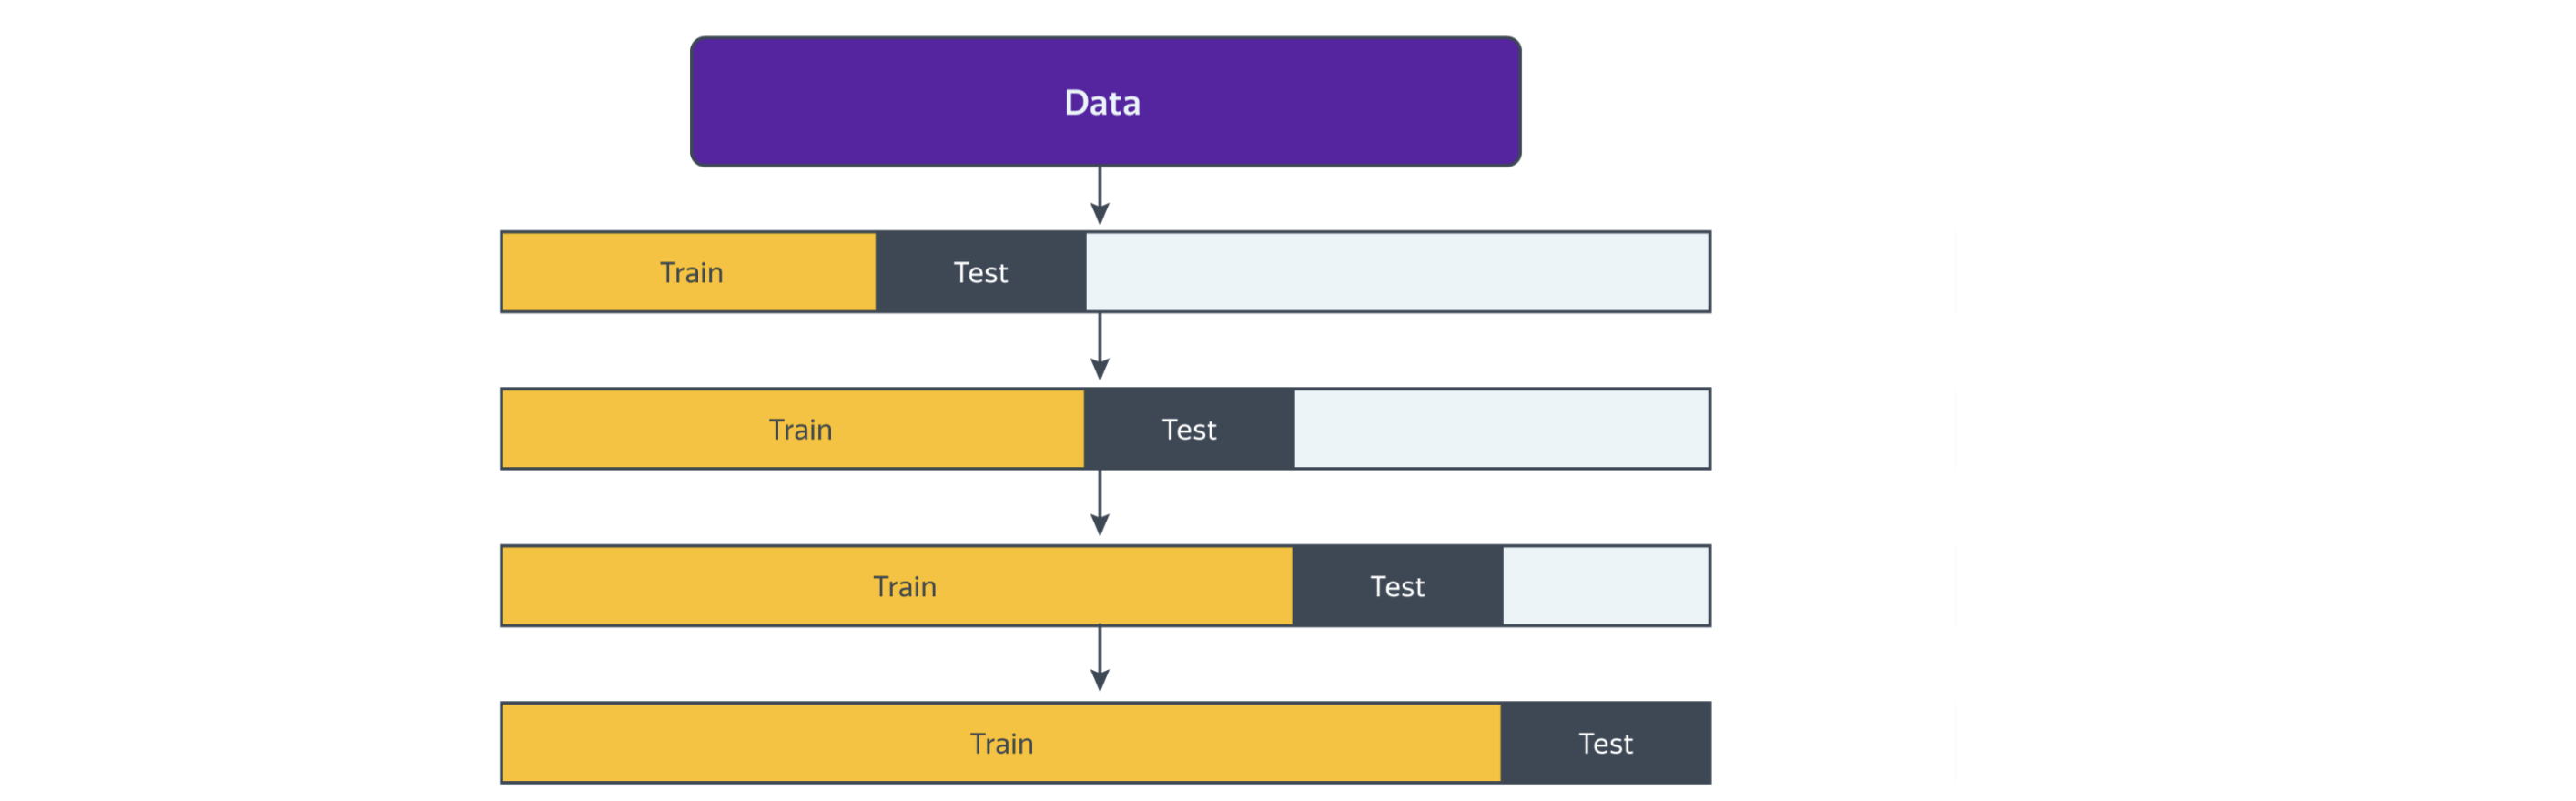

In [61]:
#Cоздание фич под каждую модель
df10 = df9.copy(deep=True)
for h in range(1, 8):
    df10[f'gmv_h{h}'] = df10['gmv'].shift(-h)
df10 = df10.dropna()

### 3.1. Разбиение на train, val и test

In [62]:
test = df10[-365:]
train_val = df10[:-365]
len(test)

365

### 3.2. Отбор признаков

Методом кросс-валидации были получены ранжированные по важности признаки датасета для каждой из 7-ми моделей и отобрана первая половина.

In [63]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

all_selected_features = {}
tscv = TimeSeriesSplit(n_splits=5)

models_feature_importance={}
for h in range(1, 8):
    X = train_val.drop(columns=[f'gmv_h{i}' for i in range(1, 8)])
    y = train_val[f'gmv_h{h}']
    
    buf = np.empty((len(X.columns),))
    #Кросс-валидация для отбора признаков
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    
        
        # Создание датасетов LightGBM
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        # Параметры модели
        params = {
            'objective': 'regression',
            'metric': 'mape',
            'boosting_type': 'gbdt',
            'verbose': -1,
            'random_state': 10,
            'num_threads': -1
        }
        
        # Обучение модели
        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            callbacks=[
                lgb.early_stopping(50, verbose=False),
                lgb.log_evaluation(0)
            ]
        )
        
        # Получение важности признаков (gain)
        feature_importances = model.feature_importance(importance_type='gain')
        buf = buf+feature_importances  
    
    # Создание DataFrame с важностями
    feature_names = model.feature_name()
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': buf
    })
    #Нормализация важностей
    importance_df['importance'] = importance_df['importance'] / importance_df['importance'].sum()
    importance_df.sort_values('importance', ascending=False, inplace=True)

    median_importance = importance_df['importance'].median()
    selected_features = importance_df[importance_df['importance'] >= median_importance]['feature'].tolist()

    models_feature_importance[f'h{h}'] = selected_features


print('Топ-5 лучших признаков для каждой модели')
for item, data in models_feature_importance.items():
    print(item)
    print(data[:5])
    print(len(data))
    print()

Топ-5 лучших признаков для каждой модели
h1
['gmv_mean7', 'day_of_week_sin', 'gmv_lag_7', 'sessions_mean30_without_promo', 'sessions_mean7']
23

h2
['gmv_mean7', 'day_of_week_sin', 'sessions_mean30_without_promo', 'gmv_mean30_without_promo', 'sessions_mean30']
23

h3
['gmv_mean7', 'sessions_mean30_without_promo', 'day_of_week_sin', 'sessions_mean7', 'gmv_lag_1']
23

h4
['gmv_mean7', 'sessions_mean7', 'gmv_lag_2', 'day_of_week_sin', 'sessions_std30']
23

h5
['gmv_lag_2', 'sessions_lag_2', 'gmv_lag_1', 'day_of_week_sin', 'sessions_mean30']
23

h6
['gmv_lag_1', 'sessions_lag_365', 'gmv_lag_2', 'gmv', 'day_of_week_sin']
23

h7
['gmv_lag_7', 'gmv', 'gmv_lag_14', 'sessions_lag_7', 'gmv_lag_1']
23



In [64]:
models = {}
for item, data in models_feature_importance.items():
    models[item] = {'best_features' : data}


train_val[models['h1']['best_features']]

,gmv_mean7,day_of_week_sin,gmv_lag_7,sessions_mean30_without_promo,sessions_mean7,marketing_spend_mean30,gmv_lag_1,sessions_lag_7,marketing_spend_mean30_without_promo,sessions_lag_14,...,gmv_lag_2,gmv_lag_28,marketing_spend_lag_7,marketing_spend_lag_28,marketing_spend_lag_1,gmv_lag_365,sessions_lag_2,gmv_mean30_without_promo,marketing_spend_lag_14,marketing_spend_lag_2
0,506994.0,-0.433884,501120.0,34861.0,34861.0,25148.0,506994.0,30796.0,25148.0,29249.0,...,506994.0,509831.0,22978.0,12199.0,25148.0,428474.0,34861.0,506994.0,17291.0,25148.0
1,476414.0,-0.974928,439960.0,33860.0,33860.0,24458.0,506994.0,28793.0,24458.0,27246.0,...,506994.0,448671.0,21599.0,10820.0,25148.0,367314.0,34861.0,476414.0,15912.0,25148.0
2,433659.0,-0.781831,342276.0,30267.0,30267.0,23675.0,445834.0,19016.0,23675.0,17469.0,...,506994.0,350987.0,19938.0,9159.0,23769.0,269630.0,34861.0,433659.0,14251.0,25148.0
3,415099.0,0.000000,353544.0,28992.0,28992.0,23196.0,348150.0,21101.0,23196.0,19554.0,...,445834.0,362255.0,19587.0,8808.0,22108.0,280898.0,32858.0,415099.0,13900.0,23769.0
4,408367.0,0.781831,375565.0,29410.0,29410.0,22840.0,359418.0,27017.0,22840.0,25470.0,...,348150.0,384276.0,19250.0,8471.0,21757.0,302919.0,23081.0,408367.0,13563.0,22108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,783416.0,0.781831,693514.0,123923.0,134442.0,40915.0,917271.0,118518.0,40085.0,95025.0,...,628890.0,751961.0,40300.0,42960.0,30470.0,500614.0,117403.0,736525.0,33876.0,27890.0
719,761242.0,0.974928,880798.0,123932.0,130192.0,40932.0,649363.0,155845.0,40103.0,124215.0,...,917271.0,739111.0,64975.0,43195.0,39500.0,508631.0,142572.0,738202.0,37320.0,30470.0
720,759311.0,0.433884,807278.0,124675.0,132763.0,40783.0,725579.0,128571.0,39949.0,158378.0,...,649363.0,822319.0,39634.0,36452.0,41201.0,584466.0,116102.0,739643.0,44467.0,39500.0
721,758534.0,-0.433884,860977.0,125745.0,134707.0,40870.0,793763.0,136135.0,40039.0,159845.0,...,725579.0,948071.0,49715.0,47385.0,38481.0,587627.0,126096.0,743658.0,51836.0,41201.0


In [65]:
train_val['gmv_'+'h1']

0      445834.0
1      348150.0
2      359418.0
3      381439.0
4      394592.0
         ...   
718    725579.0
719    793763.0
720    855540.0
721    738853.0
722    645437.0
Name: gmv_h1, Length: 723, dtype: float64

### 3.3. Подбор гиперпараметров

In [66]:
with open("optuna_log.csv", "w", newline='') as f:
    pass

for h in range(1, 8):
    import optuna
    from sklearn.model_selection import TimeSeriesSplit, cross_val_score
    from sklearn.metrics import mean_absolute_percentage_error
    import csv
    from tqdm import tqdm
    
    X, y = train_val[models[f'h{h}']['best_features']], train_val[f'gmv_h{h}']
    
    # Функция оценки
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'mape',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        }
    
        # Кросс-валидационная оценка
        scores = []
        for train_idx, val_idx in tscv.split(X):
        
            X_train, X_val = X[train_idx[0]:val_idx[0]], X[val_idx[0]:val_idx[1]+1]
            y_train, y_val = y[train_idx[0]:val_idx[0]], y[val_idx[0]:val_idx[1]+1]
    
            train_set = lgb.Dataset(X_train, label=y_train)
            val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)
            
            callbacks = [
                lgb.early_stopping(stopping_rounds=100, verbose=False),  # Отключаем логи ранней остановки
                lgb.log_evaluation(period=0),  # period=0 полностью отключает логи
            ]
            model = lgb.train(params, train_set, valid_sets=[val_set], num_boost_round=1000, 
                              callbacks=callbacks)
            
            
            y_pred = model.predict(X_val, num_iteration=model.best_iteration)
            mape = mean_absolute_percentage_error(y_val, y_pred)
            scores.append(mape)
    
        return np.mean(scores)
    
    # Запуск Optuna
    def log_trial(study, trial):
        with open("optuna_log.csv", "a", newline='') as f:
            writer = csv.writer(f)
            if trial.number == 0:  # Записываем заголовок
                writer.writerow(["trial_number", "params", "value"])
            writer.writerow([trial.number, trial.params, trial.value])
    
    
    # Обертка для отображения прогресса Optuna
    def optimize_with_progress(study, n_trials):
        with tqdm(total=n_trials, desc="Optuna Trials") as pbar:
            def update_pbar(study, trial):
                pbar.update(1)
                pbar.set_postfix({"Best MAPE": study.best_value})
            
            study.optimize(objective, n_trials=n_trials, callbacks=[log_trial, update_pbar])
    
    # Запуск Optuna с прогресс-баром
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    optimize_with_progress(study, n_trials=1000)
    

    
    print(f'Подбор параметров для модели прогнозирования на {h} день')
    print()
    
    # Output the best hyperparameters and their corresponding value
    print("Number of finished trials:", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("MAPE:", trial.value)
    print("Params:")
    for key, value in trial.params.items():
        models[f'h{h}']['best_params'] = trial.params
        print(f" {key}: {value}")


Optuna Trials: 100%|█████| 1000/1000 [03:11<00:00,  5.22it/s, Best MAPE=0.00849]


Подбор параметров для модели прогнозирования на 1 день

Number of finished trials: 1000
Best trial:
MAPE: 0.008491354352697255
Params:
 learning_rate: 0.2699278366053259
 num_leaves: 187
 max_depth: 7
 min_data_in_leaf: 10
 feature_fraction: 0.7635315682329528
 bagging_fraction: 0.763537141329643
 bagging_freq: 4
 lambda_l1: 2.3383412900236318e-08
 lambda_l2: 1.5829927619586633e-05


Optuna Trials: 100%|█████| 1000/1000 [04:16<00:00,  3.90it/s, Best MAPE=0.00765]


Подбор параметров для модели прогнозирования на 2 день

Number of finished trials: 1000
Best trial:
MAPE: 0.007648118509603517
Params:
 learning_rate: 0.21154699966889362
 num_leaves: 149
 max_depth: 10
 min_data_in_leaf: 18
 feature_fraction: 0.9410271853503552
 bagging_fraction: 0.6572962674595931
 bagging_freq: 2
 lambda_l1: 2.4229650460336826e-05
 lambda_l2: 0.19750672318152046


Optuna Trials: 100%|██████| 1000/1000 [03:47<00:00,  4.39it/s, Best MAPE=0.0405]


Подбор параметров для модели прогнозирования на 3 день

Number of finished trials: 1000
Best trial:
MAPE: 0.04052845066597891
Params:
 learning_rate: 0.17170900974313255
 num_leaves: 201
 max_depth: 7
 min_data_in_leaf: 11
 feature_fraction: 0.9601557813522901
 bagging_fraction: 0.6004871884428763
 bagging_freq: 10
 lambda_l1: 1.582431301715269e-08
 lambda_l2: 1.611254519953184e-08


Optuna Trials: 100%|███████| 1000/1000 [04:36<00:00,  3.61it/s, Best MAPE=0.039]


Подбор параметров для модели прогнозирования на 4 день

Number of finished trials: 1000
Best trial:
MAPE: 0.038992193445955364
Params:
 learning_rate: 0.07937317427730695
 num_leaves: 117
 max_depth: 15
 min_data_in_leaf: 10
 feature_fraction: 0.6444236655976112
 bagging_fraction: 0.7714029309535421
 bagging_freq: 3
 lambda_l1: 5.4174744209965404e-08
 lambda_l2: 6.319131148410779e-05


Optuna Trials: 100%|██████| 1000/1000 [04:23<00:00,  3.79it/s, Best MAPE=0.0122]


Подбор параметров для модели прогнозирования на 5 день

Number of finished trials: 1000
Best trial:
MAPE: 0.01215453728738393
Params:
 learning_rate: 0.2409290083973516
 num_leaves: 151
 max_depth: 10
 min_data_in_leaf: 10
 feature_fraction: 0.9217864920037924
 bagging_fraction: 0.6542768734669476
 bagging_freq: 5
 lambda_l1: 1.1079813217932741
 lambda_l2: 0.005785365734253723


Optuna Trials: 100%|█████| 1000/1000 [03:00<00:00,  5.53it/s, Best MAPE=0.00747]


Подбор параметров для модели прогнозирования на 6 день

Number of finished trials: 1000
Best trial:
MAPE: 0.007471311372114398
Params:
 learning_rate: 0.25892179947931115
 num_leaves: 138
 max_depth: 5
 min_data_in_leaf: 20
 feature_fraction: 0.9421318592630807
 bagging_fraction: 0.6001527654204599
 bagging_freq: 1
 lambda_l1: 0.0027359687251580335
 lambda_l2: 5.6102229514143975e-08


Optuna Trials: 100%|██████| 1000/1000 [02:43<00:00,  6.12it/s, Best MAPE=0.0107]


Подбор параметров для модели прогнозирования на 7 день

Number of finished trials: 1000
Best trial:
MAPE: 0.010706561501037172
Params:
 learning_rate: 0.27185409150242235
 num_leaves: 150
 max_depth: 4
 min_data_in_leaf: 14
 feature_fraction: 0.7076139311203145
 bagging_fraction: 0.695451794447105
 bagging_freq: 1
 lambda_l1: 1.6386225093180764e-05
 lambda_l2: 6.28037774295101e-07


### 3.4. Обучение финальной модели и ее оценка

In [74]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, r2_score

mean_test_mape = np.zeros((7,))
theils_u = np.zeros((7,))
r2_scores = np.zeros((7,))

for h in range(1, 8):
    X_train, y_train = train_val[models[f'h{h}']['best_features']], train_val[f'gmv_h{h}']
    X_test, y_test = test[models[f'h{h}']['best_features']], test[f'gmv_h{h}']
    best_params = models[f'h{h}']['best_params']

    train_set = lgb.Dataset(X_train, label=y_train)
    test_set = lgb.Dataset(X_test, label=y_test, reference=train_set)

    model_final = lgb.train(
        best_params,
        train_set,
        valid_sets=[test_set],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    models[f'h{h}']['model'] = model_final
    
    y_pred_test = model_final.predict(X_test, num_iteration=model_final.best_iteration)
    
    # MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    models[f'h{h}']['test_mape'] = test_mape
    mean_test_mape[h-1] = test_mape

    # Theil's U
    numerator = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
    denominator = np.sqrt(np.mean(y_test ** 2)) + np.sqrt(np.mean(y_pred_test ** 2))
    theil_u = numerator / denominator
    theils_u[h-1] = theil_u
    models[f'h{h}']['theils_u'] = theil_u

    # R²
    r2 = r2_score(y_test, y_pred_test)
    r2_scores[h-1] = r2
    models[f'h{h}']['r2_score'] = r2

    models[f'h{h}']['y_pred_test']=y_pred_test
    
    print(f"Test MAPE for h{h}: {test_mape:.3f}")
    print(f"Theil's U for h{h}: {theil_u:.3f}")
    print(f"R² for h{h}: {r2:.3f}")
    print("---")

print()
print(f'Средняя MAPE на тестовом датасете: {mean_test_mape.mean()*100:.1f}%')
print(f'Средний Theil’s U: {theils_u.mean():.3f}')
print(f'Средний R²: {r2_scores.mean():.3f}')

Test MAPE for h1: 0.100
Theil's U for h1: 0.070
R² for h1: 0.510
---
Test MAPE for h2: 0.110
Theil's U for h2: 0.075
R² for h2: 0.446
---
Test MAPE for h3: 0.132
Theil's U for h3: 0.094
R² for h3: 0.135
---
Test MAPE for h4: 0.125
Theil's U for h4: 0.094
R² for h4: 0.159
---
Test MAPE for h5: 0.108
Theil's U for h5: 0.077
R² for h5: 0.403
---
Test MAPE for h6: 0.092
Theil's U for h6: 0.066
R² for h6: 0.543
---
Test MAPE for h7: 0.089
Theil's U for h7: 0.064
R² for h7: 0.571
---

Средняя MAPE на тестовом датасете: 10.8%
Средний Theil’s U: 0.077
Средний R²: 0.395


### Интерпретация оценки моделей

Средняя MAPE на тестовом датасете: 10.8% - означает, что в среднем модели ошибаются на 10% от истинного значения
_________________
Средний Theil’s U: 0.077 - модели лучше наивного прогноза

U < 1 – модель лучше наивного прогноза (предсказывает лучше, чем просто последнее значение).

U = 1 – эквивалентна наивному прогнозу.

U > 1 – хуже наивного прогноза.
_________________
Средний R²: 0.395 - модели предсказывает лучше чем предсказание средним, но до идельного предсказания далеко

1 – идеальное предсказание.

0 – модель не лучше, чем предсказание средним.

< 0 – модель хуже, чем предсказание средним.

/var/folders/vv/yqpjdvl14m5bv0mqgk7jgnlr0000gn/T/ipykernel_84825/2221818910.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'gmv_h{h}_pred'] = y_pred_test


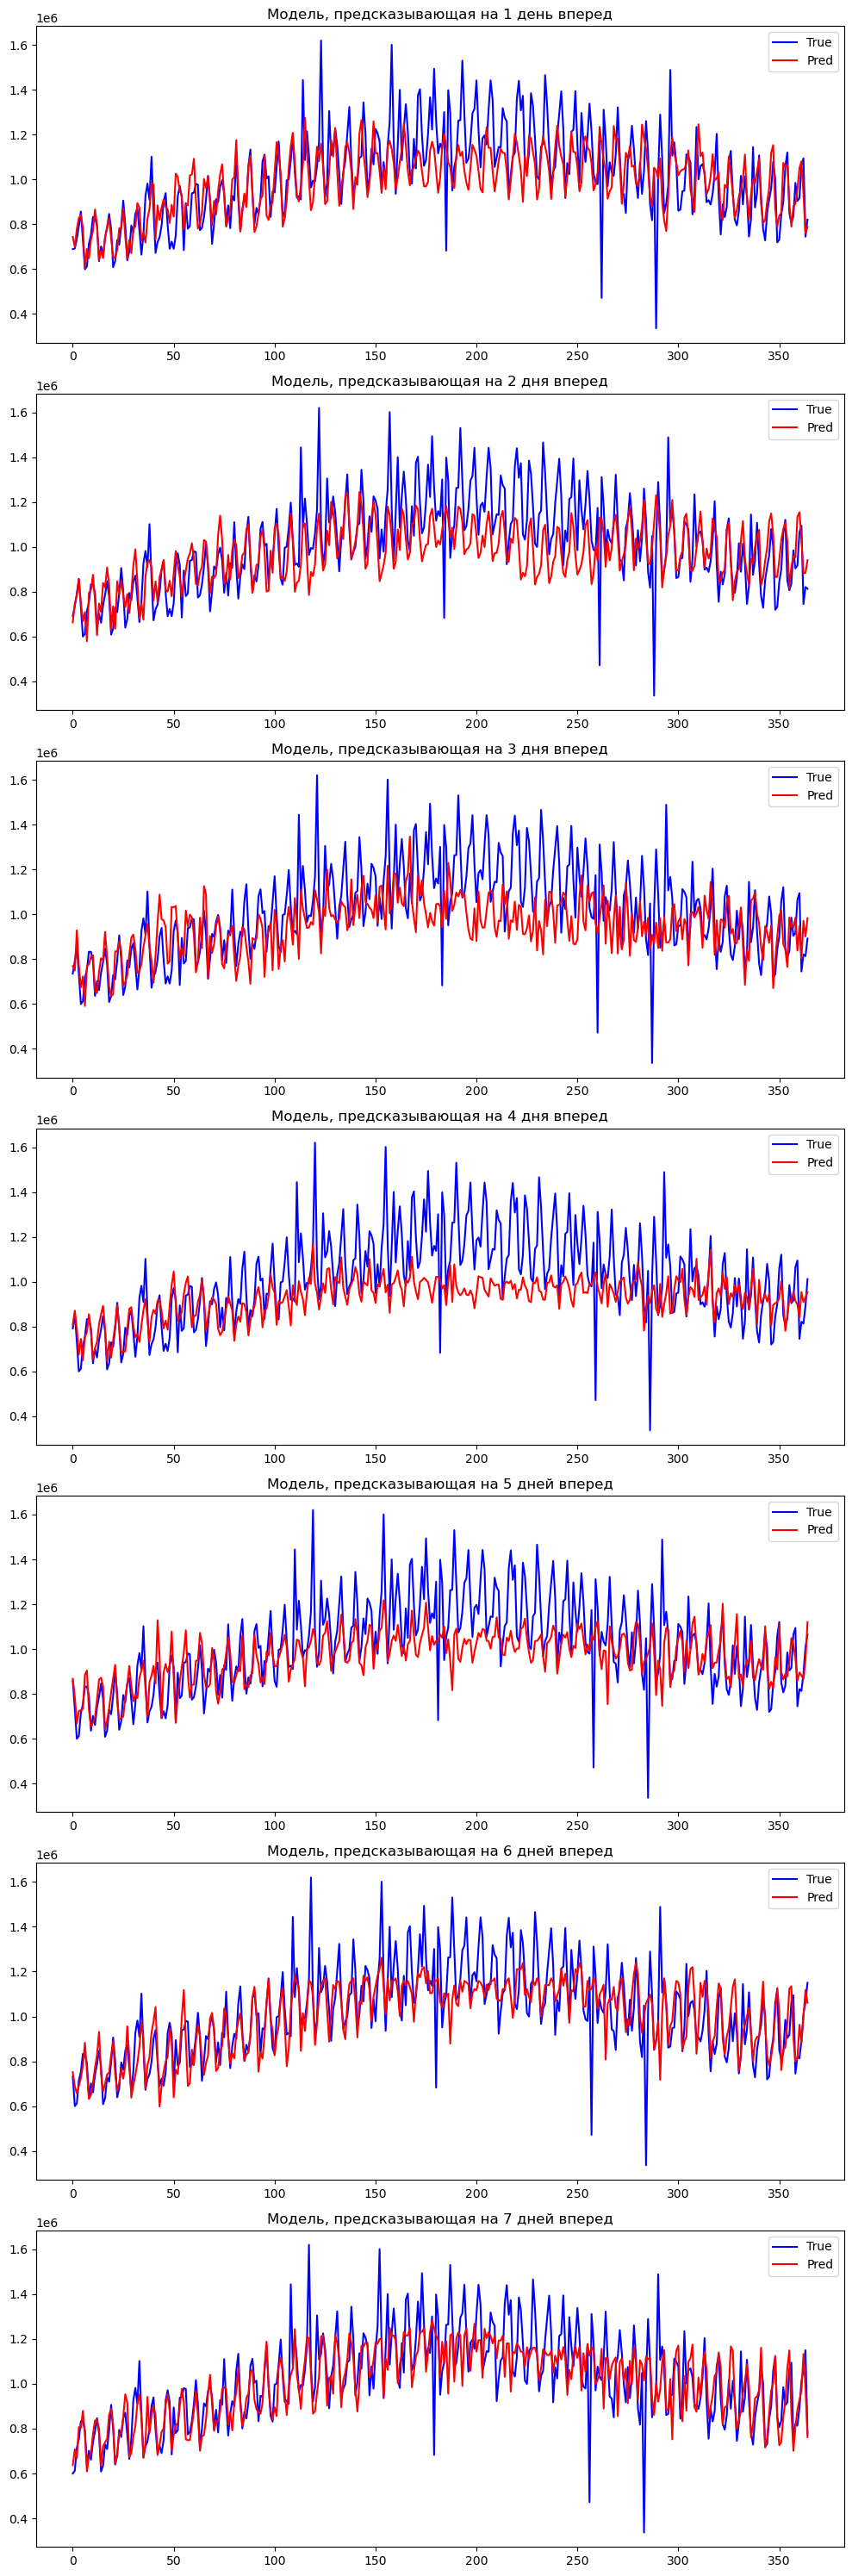

In [75]:
plt.figure(figsize=(10,30))

for h in range(1, 8):
    y_pred_test = models[f'h{h}']['y_pred_test']
    y_test = test[f'gmv_h{h}'].values

    test[f'gmv_h{h}_pred'] = y_pred_test

    plt.subplot(7, 1, h)
    plt.plot(y_test, c = 'b', label='True')
    plt.plot(y_pred_test, c = 'r', label='Pred')
    plt.legend()
    plt.title(f'Модель, предсказывающая на {h} {'день' if h==1 else ('дня' if (h>1 and h<5) else 'дней')} вперед')



plt.tight_layout()
plt.show()

In [78]:
df10.columns

Index(['gmv', 'sessions', 'marketing_spend', 'is_promo_active',
       'holiday_proximity', 'gmv_lag_1', 'sessions_lag_1',
       'marketing_spend_lag_1', 'gmv_lag_2', 'sessions_lag_2',
       'marketing_spend_lag_2', 'gmv_lag_7', 'sessions_lag_7',
       'marketing_spend_lag_7', 'gmv_lag_14', 'sessions_lag_14',
       'marketing_spend_lag_14', 'gmv_lag_28', 'sessions_lag_28',
       'marketing_spend_lag_28', 'gmv_lag_365', 'sessions_lag_365',
       'marketing_spend_lag_365', 'gmv_mean7', 'gmv_mean30', 'sessions_mean7',
       'sessions_mean30', 'marketing_spend_mean7', 'marketing_spend_mean30',
       'gmv_std7', 'gmv_std30', 'sessions_std7', 'sessions_std30',
       'marketing_spend_std7', 'marketing_spend_std30',
       'gmv_mean30_with_promo', 'gmv_mean30_without_promo',
       'sessions_mean30_with_promo', 'sessions_mean30_without_promo',
       'marketing_spend_mean30_with_promo',
       'marketing_spend_mean30_without_promo', 'day_of_week_sin',
       'week_of_year_sin', 'day_o

In [79]:
for h in range(1, 8):
    print(f'Модель, предсказывающая на {h} {'день' if h==1 else ('дня' if (h>1 and h<5) else 'дней')} вперед')
    print(f'Топ-5 признаков {models[f'h{h}']['best_features'][:5]}')
    print()

Модель, предсказывающая на 1 день вперед
Топ-5 признаков ['gmv_mean7', 'day_of_week_sin', 'gmv_lag_7', 'sessions_mean30_without_promo', 'sessions_mean7']

Модель, предсказывающая на 2 дня вперед
Топ-5 признаков ['gmv_mean7', 'day_of_week_sin', 'sessions_mean30_without_promo', 'gmv_mean30_without_promo', 'sessions_mean30']

Модель, предсказывающая на 3 дня вперед
Топ-5 признаков ['gmv_mean7', 'sessions_mean30_without_promo', 'day_of_week_sin', 'sessions_mean7', 'gmv_lag_1']

Модель, предсказывающая на 4 дня вперед
Топ-5 признаков ['gmv_mean7', 'sessions_mean7', 'gmv_lag_2', 'day_of_week_sin', 'sessions_std30']

Модель, предсказывающая на 5 дней вперед
Топ-5 признаков ['gmv_lag_2', 'sessions_lag_2', 'gmv_lag_1', 'day_of_week_sin', 'sessions_mean30']

Модель, предсказывающая на 6 дней вперед
Топ-5 признаков ['gmv_lag_1', 'sessions_lag_365', 'gmv_lag_2', 'gmv', 'day_of_week_sin']

Модель, предсказывающая на 7 дней вперед
Топ-5 признаков ['gmv_lag_7', 'gmv', 'gmv_lag_14', 'sessions_lag_7', 

Как можно увидеть на графиках модель очень плохо улавливает "горб" во второй половине графика, что скорее всего и вносит основной вклад в MAPE. При том что она плохо улавливает годовую сезонность, недельная сезонность хорошо усвоена

А ниже можно увидеть вероятную причину этого, хоть я и добавил признаки отражающие сознность модель им не доваеряет и предпочитает краткосрочные метрики. 

Значит улучшение данной модели должно быть направлено в сторону улушчения признаков сезонности с целью повышения интерпритируемости моделью. Возможно это так же означает, что следует попробовать сатистические модели лучше улавливающие сознность или рекурентные нейронные сети, хорошо запоминающие предыдущие состояния.

#### Подготовка к заданию 1.2

In [83]:
test

,gmv,sessions,marketing_spend,is_promo_active,holiday_proximity,gmv_lag_1,sessions_lag_1,marketing_spend_lag_1,gmv_lag_2,sessions_lag_2,...,gmv_h5,gmv_h6,gmv_h7,gmv_h1_pred,gmv_h2_pred,gmv_h3_pred,gmv_h4_pred,gmv_h5_pred,gmv_h6_pred,gmv_h7_pred
723,645437,104083,39114,0,0.3,738853.0,130017.0,41696.0,855540.0,149745.0,...,857564.0,732198.0,599808.0,7.442885e+05,6.634697e+05,768407.474241,807991.052820,8.673689e+05,7.512906e+05,6.372428e+05
724,689541,116832,33277,0,0.4,645437.0,104083.0,39114.0,738853.0,130017.0,...,732198.0,599808.0,612191.0,6.989958e+05,7.479832e+05,749199.839734,870826.671933,7.863977e+05,6.873094e+05,7.077229e+05
725,692199,124595,44235,0,0.5,689541.0,116832.0,33277.0,645437.0,104083.0,...,599808.0,612191.0,714778.0,7.787556e+05,7.830570e+05,928477.764890,791565.851314,6.673664e+05,6.570410e+05,6.687433e+05
726,735322,140200,40827,0,0.6,692199.0,124595.0,44235.0,689541.0,116832.0,...,612191.0,714778.0,753060.0,8.283207e+05,8.561251e+05,770540.720369,674495.646540,7.241136e+05,6.897822e+05,8.068150e+05
727,791911,117053,44418,0,0.7,735322.0,140200.0,40827.0,692199.0,124595.0,...,714778.0,753060.0,833057.0,8.419757e+05,7.502645e+05,673611.175528,744164.166054,7.273202e+05,7.247324e+05,8.025771e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,904286,171864,59289,0,0.0,984894.0,217197.0,78000.0,835842.0,162493.0,...,821138.0,813321.0,891794.0,1.051757e+06,1.154947e+06,946768.999130,840027.795680,8.959911e+05,9.626409e+05,9.284464e+05
1084,917091,177000,59479,0,0.0,904286.0,171864.0,59289.0,984894.0,217197.0,...,813321.0,891794.0,1011484.0,1.081294e+06,1.035554e+06,804445.977861,953560.132320,8.818308e+05,8.827977e+05,9.707866e+05
1085,1065055,202914,66889,0,0.0,917091.0,177000.0,59479.0,904286.0,171864.0,...,891794.0,1011484.0,1064332.0,9.357827e+05,8.815979e+05,970529.552430,908766.056401,8.670017e+05,9.997697e+05,1.132746e+06
1086,1094506,240418,87004,1,0.0,1065055.0,202914.0,66889.0,917091.0,177000.0,...,1011484.0,1064332.0,1150266.0,7.610610e+05,8.847006e+05,901201.680732,930568.745798,9.528221e+05,1.118427e+06,9.793574e+05


In [ ]:
test.to_csv('test.csv')

Для валидационных холдов переобучаем модели и рассчитываем  предсказания, для вычисления стандартного отклонения 

In [81]:
preds = []

for h in range(1, 8):
    import optuna
    from sklearn.model_selection import TimeSeriesSplit, cross_val_score
    from sklearn.metrics import mean_absolute_percentage_error
    import csv
    from tqdm import tqdm
    
    X, y = train_val[models[f'h{h}']['best_features']], train_val[f'gmv_h{h}']
    best_params = models[f'h{h}']['best_params']
    
    
    valid_holds = []
    val_indexes = []
    
    # Кросс-валидационная оценка
    for train_idx, val_idx in tscv.split(X):
    
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_set = lgb.Dataset(X_train, label=y_train)
        val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=False),  # Отключаем логи ранней остановки
            lgb.log_evaluation(period=0),  # period=0 полностью отключает логи
        ]
        model = lgb.train(best_params, train_set, valid_sets=[val_set], num_boost_round=1000, 
                          callbacks=callbacks)
        
        
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        
        valid_hold = pd.Series(y_pred, index=val_idx, name=f'h{h}_pred')
        valid_holds.append(valid_hold)
        val_indexes += list(val_idx)

    valid_holds = pd.concat(valid_holds, axis=0)
    preds.append(valid_holds)

preds = pd.concat(preds, axis=1)
val = train_val.iloc[val_indexes]
val_holds_full = pd.concat([val, preds], axis=1)
val_holds_full

,gmv,sessions,marketing_spend,is_promo_active,holiday_proximity,gmv_lag_1,sessions_lag_1,marketing_spend_lag_1,gmv_lag_2,sessions_lag_2,...,gmv_h5,gmv_h6,gmv_h7,h1_pred,h2_pred,h3_pred,h4_pred,h5_pred,h6_pred,h7_pred
123,663519,60158,34334,0,0.0,564122.0,67741.0,25079.0,558143.0,57911.0,...,591265.0,595118.0,662747.0,645767.902352,750640.528181,759184.165192,667792.341686,625566.431509,598240.894990,677865.172757
124,657336,70233,27752,0,0.0,663519.0,60158.0,34334.0,564122.0,67741.0,...,595118.0,662747.0,690988.0,738282.443568,776355.684192,670279.210536,590317.900584,572455.740614,702275.314651,676877.586573
125,763833,61162,39939,0,0.0,657336.0,70233.0,27752.0,663519.0,60158.0,...,662747.0,690988.0,753710.0,668347.859006,669621.077392,601414.793658,655388.233048,668205.098275,672980.070243,602823.292970
126,767657,73199,41843,0,0.0,763833.0,61162.0,39939.0,657336.0,70233.0,...,690988.0,753710.0,807389.0,682840.915874,566950.115477,627814.185091,635654.646370,624752.769267,702787.846034,740662.658230
127,665068,64935,33423,0,0.0,767657.0,73199.0,41843.0,763833.0,61162.0,...,753710.0,807389.0,629273.0,550381.512452,580157.943472,611861.329536,600406.365329,665868.061409,758880.475301,700076.089535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,649363,116102,39500,0,0.0,917271.0,142572.0,30470.0,628890.0,117403.0,...,645437.0,689541.0,692199.0,860044.717333,832043.869065,841534.626209,790682.969294,651303.839052,820001.987720,685676.719963
719,725579,126096,41201,0,0.0,649363.0,116102.0,39500.0,917271.0,142572.0,...,689541.0,692199.0,735322.0,842035.425390,887865.017439,860443.535808,773457.073910,877733.310287,759437.199597,796702.778128
720,793763,146565,38481,0,0.0,725579.0,126096.0,41201.0,649363.0,116102.0,...,692199.0,735322.0,791911.0,843858.723399,812568.196914,841534.626209,836814.978694,712992.137516,766749.663223,853744.155671
721,855540,149745,45796,0,0.1,793763.0,146565.0,38481.0,725579.0,126096.0,...,735322.0,791911.0,857564.0,835173.803239,710060.826820,860443.535808,839247.230012,787988.965546,864011.225567,871255.916995


In [82]:
val_holds_full.to_csv('val_holds_full.csv')